## Explore Word Trends in Academic Publications Data

Mucun Tian

### Load Library

In [1]:
library(tidytext)
library(tidyverse)
library(dbplyr)
library(RcppRoll)
library(doParallel)
registerDoParallel()

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘dbplyr’

The following objects are masked from ‘package:dplyr’:

    ident, sql

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel


options

In [2]:
options(repr.matrix.max.rows=10)
options(repr.plot.height=5)

### Create a database connection

In [3]:
db = src_sqlite('ejc-trimmed.db')

### Access tables

In [4]:
articles = db %>% tbl('articles')
journals = db %>% tbl('journals')

In [5]:
head(articles)
head(journals)

# Source:   lazy query [?? x 9]
# Database: sqlite 3.19.3 [/home/MucunTian/notebooks/hw5/ejc-trimmed.db]
  article_id             doi          jnl_id
       <int>           <chr>           <chr>
1          2 10.2307/1004752 10.2307/j100438
2          3 10.2307/1004753 10.2307/j100438
3          4 10.2307/1004754 10.2307/j100438
4          5 10.2307/1004755 10.2307/j100438
5          6 10.2307/1004756 10.2307/j100438
6          7 10.2307/1004757 10.2307/j100438
# ... with 6 more variables: journal <chr>, volume <int>, year <int>,
#   pub_date <chr>, title <chr>, text <chr>

# Source:   lazy query [?? x 2]
# Database: sqlite 3.19.3 [/home/MucunTian/notebooks/hw5/ejc-trimmed.db]
             jnl_id      name
              <chr>     <chr>
1   10.2307/j100438    AmPhil
2   10.2307/j100835 RoyalPhil
3 10.2307/j50000139     AmRev
4 10.2307/j50000720  AdvPeace
5   10.2307/j100000   Science

### Preliminary Exploration 

Let's first look at a use-by-rank distribution of the words used in the corpus for each journal.

Show journals' name

In [6]:
journals %>%
    select(name) %>%
    distinct() %>%
    collect()

name     
1 AmPhil   
2 RoyalPhil
3 AmRev    
4 AdvPeace 
5 Science

Get article text words group by journals

In [7]:
journal.words = journals %>%
    inner_join(articles) %>%
    filter(!is.na(text)) %>%
    select(name, text) %>%
    collect() %>%
    unnest_tokens(word, text)

Joining, by = "jnl_id"


Count text words per journal

In [8]:
journal.words.stats = journal.words %>%
    group_by(name, word) %>%
    summarize(count=n()) %>%
    ungroup()
journal.words.stats

name     word     count
1       AdvPeace __       18   
2       AdvPeace ___       7   
3       AdvPeace ______    2   
4       AdvPeace _______   2   
5       AdvPeace ________  4   
⋮       ⋮        ⋮        ⋮    
2116036 Science  zzzjrera 1    
2116037 Science  zzzoner  1    
2116038 Science  zzzs     1    
2116039 Science  zzzy     2    
2116040 Science  zzzz     1

Get article title words

In [9]:
journal.title.words = journals %>%
    inner_join(articles) %>%
    filter(!is.na(title)) %>%
    select(name, title) %>%
    collect() %>%
    unnest_tokens(word, title)

Joining, by = "jnl_id"


Count title words per journal

In [10]:
journal.title.words.stats = journal.title.words %>%
    group_by(name, word) %>%
    summarize(titleWordsCount=n()) %>%
    ungroup()
journal.title.words.stats

name     word       titleWordsCount
1     AdvPeace 1           6             
2     AdvPeace 10          9             
3     AdvPeace 100,000     2             
4     AdvPeace 11         10             
5     AdvPeace 11th        1             
⋮     ⋮        ⋮          ⋮              
44602 Science  zygospores 3              
44603 Science  β          2              
44604 Science  γ          2              
44605 Science  δ          1              
44606 Science  μ          1

Join all words to form a corpus 

In [12]:
corpus.words.stats = full_join(journal.words.stats, journal.title.words.stats) %>%
    mutate(count = ifelse(is.na(count), 0, count),
           titleWordsCount = ifelse(is.na(titleWordsCount), 0, titleWordsCount),
           totalCount = count + titleWordsCount) %>%
    select(name, word, totalCount)
# corpus.words.stats

Joining, by = c("name", "word")


Compute the rank of word counts per journal (without ties)

In [13]:
corpus.words.rank = corpus.words.stats %>%
    group_by(name) %>%
    mutate(rank=row_number(-totalCount)) %>%
    ungroup() %>%
    rename(count=totalCount)

Plot it

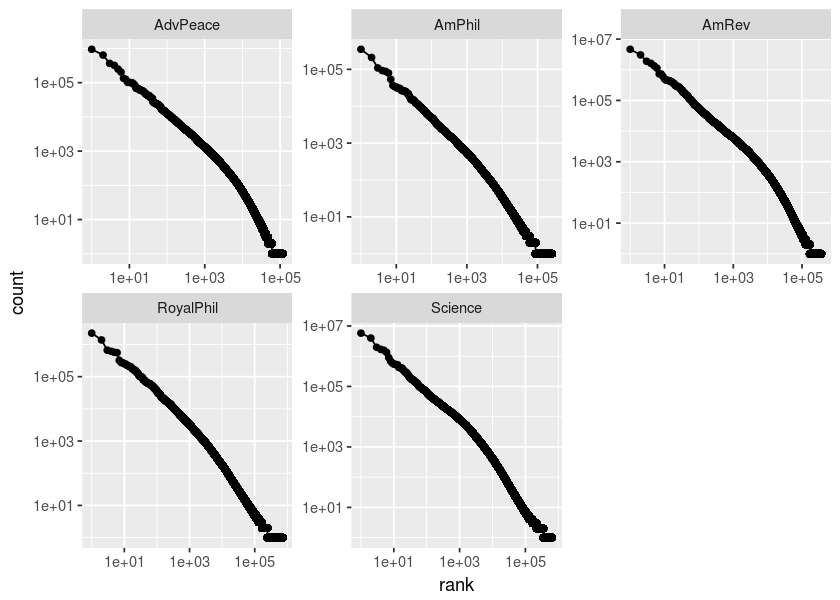

In [14]:
ggplot(corpus.words.rank) +
    aes(x=rank, y=count) +
    geom_line() +
    geom_point() +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap(~name, scales='free')

The 10 most common words in each journal.

In [15]:
top.10.common.words = corpus.words.rank %>%
    filter(rank <= 10) %>%
    group_by(name) %>%
    arrange(rank, .by_group=TRUE) %>%
    ungroup() %>%
    select(name, word, count, rank)

Show top 10 common words in each journal

In [16]:
bind_cols(top.10.common.words %>%
    filter(name=='AdvPeace') %>%
    spread(name, word) %>%
    select(AdvPeace, count) %>%
    arrange(-count),
         top.10.common.words %>%
    filter(name=='AmPhil') %>%
    spread(name, word) %>%
    select(AmPhil, count) %>%
    arrange(-count),
         top.10.common.words %>%
    filter(name=='AmRev') %>%
    spread(name, word) %>%
    select(AmRev, count) %>%
    arrange(-count),
         top.10.common.words %>%
    filter(name=='RoyalPhil') %>%
    spread(name, word) %>%
    select(RoyalPhil, count) %>%
    arrange(-count),
         top.10.common.words %>%
    filter(name=='Science') %>%
    spread(name, word) %>%
    select(Science, count) %>%
    arrange(-count)) %>%
    rename(count = count1, count=count2, count=count3, count=count4)

AdvPeace count  AmPhil count  AmRev count   RoyalPhil count   Science
1  the      945564 the    349369 the   4665734 the       2245530 the    
2  of       640922 of     209609 of    3060752 of        1381752 of     
3  and      365611 and    108844 and   1898953 and        664412 and    
4  to       320370 in      92592 to    1628218 in         610721 in     
5  in       249157 a       87933 in    1338793 a          569282 to     
6  a        203745 to      79483 a     1130297 to         555894 a      
7  that     134019 is      53588 that   733950 i          321623 is     
8  is       125072 i       36718 is     727805 is         274644 that   
9  for      102422 by      33731 it     605344 that       270115 by     
10 it       101759 it      33120 as     504701 it         251178 as     
   count  
1  5794268
2  3988515
3  1978006
4  1689631
5  1569490
6  1339830
7   895746
8   685209
9   595521
10  547562

Plot it

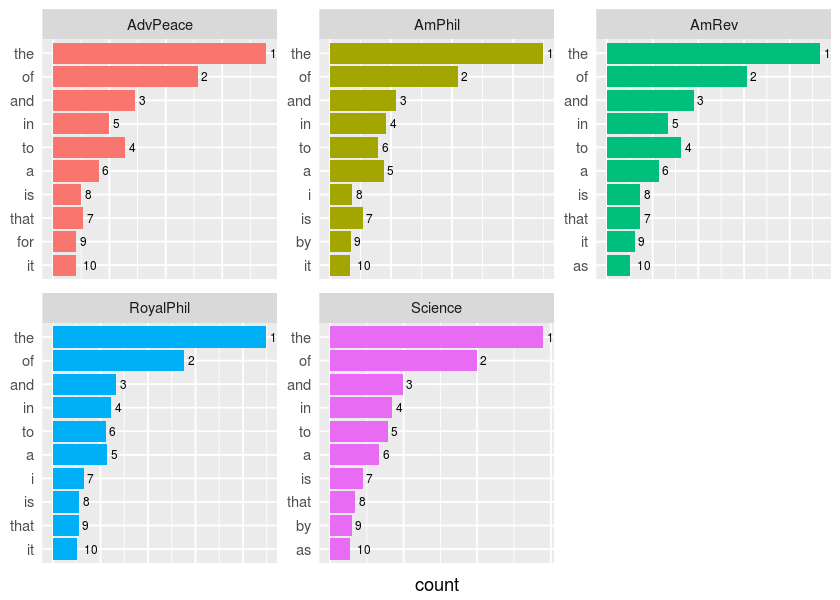

In [17]:
ggplot(top.10.common.words) +
    aes(x=reorder(word, -rank), y=count, fill=name) +
    geom_col() +
    geom_text(mapping=aes(label=rank), size = 2.5, hjust = -0.5) +
    coord_flip() +
    labs(x = NULL) +
    theme(axis.text.x = element_blank(),
          axis.ticks = element_blank(),
          legend.position="none") +
    facet_wrap(~name, scales='free')

### Word Distributions

Let's look at what 5-10 words see the greatest **increase**, **decrease** and **consistently frequently** in use over time?

We are going to explore it separately for **each journal** and over **the entire corpus**, and also for article **text** and for **titles**.

In this section, we will investigate word distribution after removing stop words since this may give us more informaiton about topical changes.

#### _For each Journal_

Get the words in **titles**

In [18]:
title.words.year = journals %>%
    inner_join(articles) %>%
    filter(!is.na(title), !is.na(year)) %>%
    select(name, title, year) %>%
    collect() %>%
    unnest_tokens(word, title) %>%
    anti_join(stop_words)
# title.words.year

Joining, by = "jnl_id"
Joining, by = "word"


**Article Titles of Journal AdvPeace**

In [19]:
title.words.adv = title.words.year %>%
    filter(name=='AdvPeace')
# title.words.adv

Compute word count and frequency per year

In [20]:
title.words.adv.stats = title.words.adv %>%
    count(name, year, word) %>%
    ungroup() 
title.words.adv.stats = title.words.adv.stats %>%
    group_by(name, year) %>%
    summarize(count_year=sum(n)) %>%
    ungroup() %>%
    inner_join(title.words.adv.stats) %>%
    mutate(freq = n / count_year)
title.words.adv.stats

Joining, by = c("name", "year")


name     year count_year word       n freq       
1     AdvPeace 1834 62         affairs    2 0.03225806 
2     AdvPeace 1834 62         age        1 0.01612903 
3     AdvPeace 1834 62         auxiliary  1 0.01612903 
4     AdvPeace 1834 62         benevolent 1 0.01612903 
5     AdvPeace 1834 62         condition  1 0.01612903 
⋮     ⋮        ⋮    ⋮          ⋮          ⋮ ⋮          
12522 AdvPeace 1922 629        workers    1 0.001589825
12523 AdvPeace 1922 629        world      4 0.006359300
12524 AdvPeace 1922 629        wounded    1 0.001589825
12525 AdvPeace 1922 629        wrong      1 0.001589825
12526 AdvPeace 1922 629        yap        1 0.001589825

We are going to look at changes of word frequencies over year

First, check year range.

In [21]:
title.words.adv.stats %>%
    group_by(name) %>%
    summarize(start=min(year),
              end=max(year))

name     start end 
1 AdvPeace 1834  1922

Year range of AdvPeace journal is from 1834 to 1922.

Check missing year

In [22]:
title.words.adv.stats %>%
    select(year) %>%
    distinct() %>%
    mutate(last_year = lag(year, default = min(year)),
           diff = year - last_year) %>%
    filter(diff > 1)

year last_year diff
1 1850 1848       2  
2 1869 1856      13  
3 1889 1869      20

For this journal, there are four periods: 1834 - 1848, 1850 - 1856, 1869 - 1869, 1889 - 1922. For other periods, we don't have data.

So we are goint to look at words increasing within and between these 4 periods.

And we also only consider words that continuously increase more than 5 years.

Compute word frequency difference between two adjacent years

In [23]:
title.words.adv.freq = title.words.adv.stats %>%
    select(name, word, year, freq) %>%
    group_by(name, word) %>%
    arrange(year) %>%
    mutate(freq_next = lead(freq),
           year_next = lead(year),
           freq_diff = freq_next - freq,
           year_diff = year_next - year) %>%
    ungroup() %>%
    drop_na() %>% # drop last year in which a word appears
    select(name, word, year, year_next, year_diff, freq, freq_next, freq_diff)
title.words.adv.freq

name     word       year year_next year_diff freq        freq_next  
1    AdvPeace affairs    1834 1835       1        0.03225806  0.024096386
2    AdvPeace age        1834 1840       6        0.01612903  0.006493506
3    AdvPeace auxiliary  1834 1843       9        0.01612903  0.011976048
4    AdvPeace benevolent 1834 1869      35        0.01612903  0.001315789
5    AdvPeace condition  1834 1843       9        0.01612903  0.005988024
⋮    ⋮        ⋮          ⋮    ⋮         ⋮         ⋮           ⋮          
8050 AdvPeace washington 1921 1922      1         0.001282051 0.006359300
8051 AdvPeace world      1921 1922      1         0.003846154 0.006359300
8052 AdvPeace wounded    1921 1922      1         0.001282051 0.001589825
8053 AdvPeace wrong      1921 1922      1         0.001282051 0.001589825
8054 AdvPeace yap        1921 1922      1         0.002564103 0.001589825
     freq_diff    
1    -0.008161679 
2    -0.009635526 
3    -0.004152984 
4    -0.014813243 
5    -0.010141008 
⋮    ⋮            
8050  0.0050772492
8051  0.0025131466
8052  0.0003077738
8053  0.0003077738
8054 -0.0009742774

For year 1834 - 1848 
- find incresing periods for each word, which are rows with positive value of `freq_diff`
- find words that continuously increase more than 5 years, which are words with `roll_sum` of `year_diff` equal to 5 and `roll_min` of `freq_diff` greater than 0

Define functions to find words having monotonic increasing or decreasing periods of length at least `period`

In [24]:
monotonicIncrease = function(data, yearFrom, yearTo, period) {
    data %>%
    filter(year >= yearFrom, year <= yearTo) %>%
    group_by(name, word) %>%
    mutate(continous_year = roll_sum(year_diff, period, fill = NA),
           continous_increase = roll_min(freq_diff, period, fill = NA)) %>%
    ungroup() %>%
    filter(continous_year==period, continous_increase > 0) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup()
}

In [25]:
monotonicDecrease = function(data, yearFrom, yearTo, period) {
    data %>%
    filter(year >= yearFrom, year <= yearTo) %>%
    group_by(name, word) %>%
    mutate(continous_year = roll_sum(year_diff, period, fill = NA),
           continous_increase = roll_max(freq_diff, period, fill = NA)) %>%
    ungroup() %>%
    filter(continous_year==period, continous_increase < 0) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup()
}

In [26]:
title.words.adv.first = monotonicIncrease(title.words.adv.freq, 1834, 1848, 5)
title.words.adv.first

name     word freq_increase
1 AdvPeace war  0.02006377

In this period, word _war_ is the trending word.

Joining, by = c("name", "word")


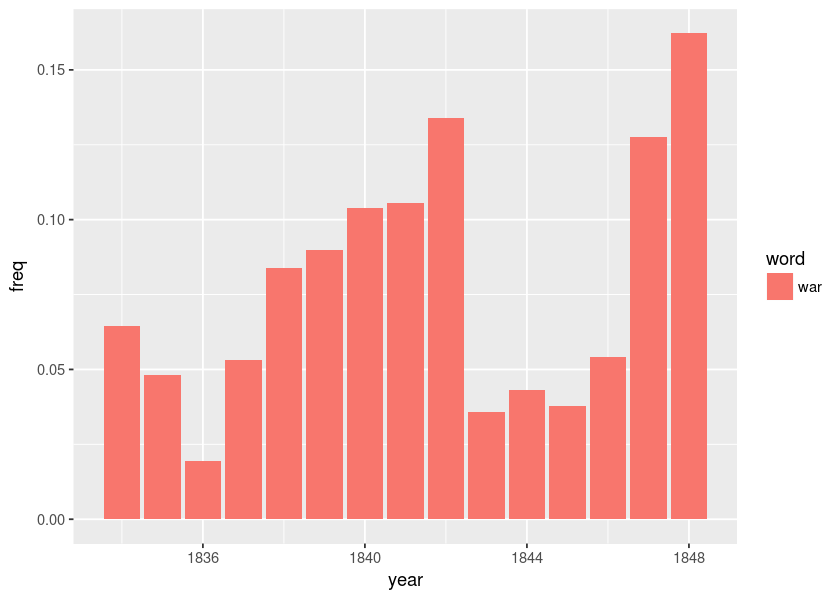

In [27]:
title.words.adv.freq %>% 
    filter(year > 1833, year < 1849) %>%
    inner_join(title.words.adv.first) %>%
    ggplot() +
    aes(x = year, y = freq, fill = word) +
    geom_bar(stat = 'identity', position = 'dodge') 

For year 1848 - 1850, we look at words appeared in 1847 or 1848 and reappeared in 1850 or 1851 and their frequency change.

In [28]:
title.words.adv.second = title.words.adv.freq %>%
    filter(year_next == 1850 | year_next == 1851, year == 1848 | year == 1847) %>%
    arrange(-freq_diff) %>%
    head(10)
title.words.adv.second
    
title.words.adv.plot = title.words.adv.second %>%
    select(name, word, year, freq) %>%
    bind_rows(title.words.adv.second %>%
                select(name, word, year=year_next, freq=freq_next))

name     word        year year_next year_diff freq        freq_next 
1  AdvPeace peace       1848 1850      2         0.067567568 0.25000000
2  AdvPeace congress    1848 1850      2         0.006756757 0.08333333
3  AdvPeace fourth      1847 1850      3         0.010638298 0.08333333
4  AdvPeace home        1848 1850      2         0.013513514 0.08333333
5  AdvPeace matter      1848 1850      2         0.020270270 0.08333333
6  AdvPeace address     1848 1851      3         0.006756757 0.03061224
7  AdvPeace annual      1847 1851      4         0.010638298 0.02040816
8  AdvPeace london      1848 1851      3         0.006756757 0.01020408
9  AdvPeace report      1848 1851      3         0.006756757 0.01020408
10 AdvPeace resolutions 1848 1851      3         0.006756757 0.01020408
   freq_diff  
1  0.182432432
2  0.076576577
3  0.072695035
4  0.069819820
5  0.063063063
6  0.023855488
7  0.009769865
8  0.003447325
9  0.003447325
10 0.003447325

Plot it by frequency v.s. year

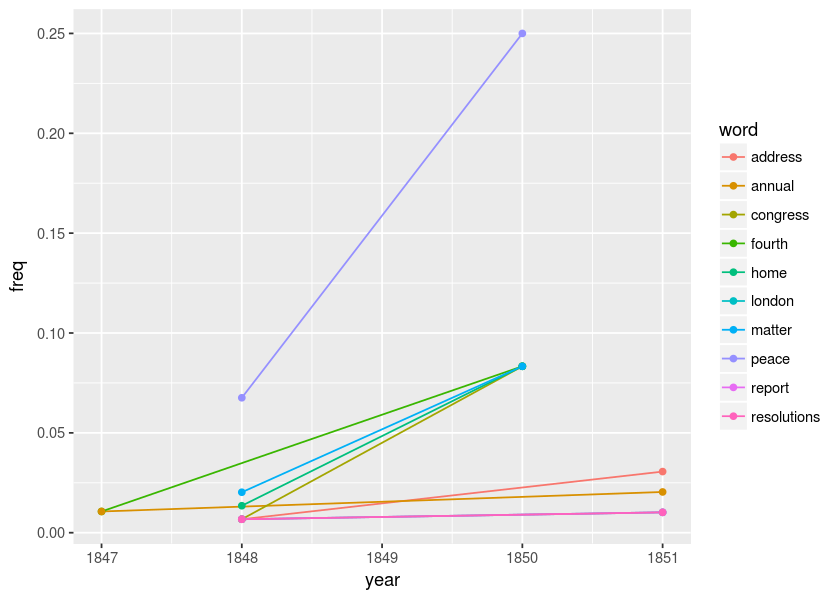

In [29]:
ggplot(title.words.adv.plot) +
    aes(x = year, y = freq, color = word) +
    geom_line() +
    geom_point()

We can see that during this period, **_peace, home, congress, fourth, matter, london_** have huge increasing.

For year 1850 - 1856, we look at words that continously increase in at least 2 years.

In [30]:
title.words.adv.third = monotonicIncrease(title.words.adv.freq, 1850, 1856, 2)
title.words.adv.third

name     word     freq_increase
1 AdvPeace american 0.005876068  
2 AdvPeace eastern  0.013197587  
3 AdvPeace report   0.005159959  
4 AdvPeace war      0.039844143

Plot it

Joining, by = c("name", "word")


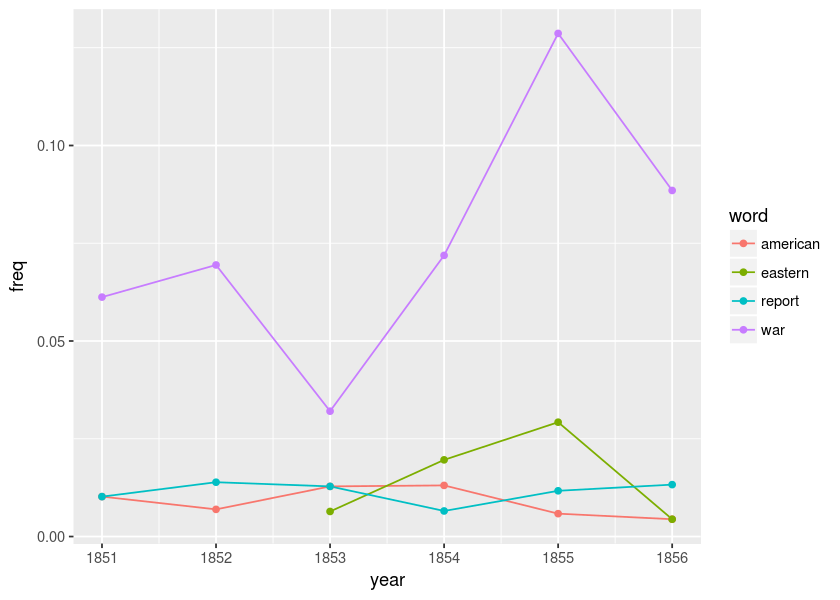

In [31]:
title.words.adv.freq %>% 
    filter(year >= 1850, year <= 1856) %>%
    inner_join(title.words.adv.third) %>%
    ggplot() +
    aes(x = year, y = freq, color = word) +
    geom_line() +
    geom_point()

We see that **_war, eastern, report, american_** have huge increasing in certain two year periods.

For year 1857 - 1868, since we don't have data for this period, we look at words appeared in 1855 or 1856 and reappeared in 1868 or 1869 and their frequency change.

In [32]:
title.words.adv.fourth = title.words.adv.freq %>%
    filter(year == 1856 | year == 1855, year_next == 1868 | year_next == 1869) %>%
    filter(freq_diff > 0) %>%
    arrange(-freq_diff) %>%
    head(10)
title.words.adv.fourth

title.words.adv.plot = title.words.adv.fourth %>%
    select(name, word, year, freq) %>%
    bind_rows(title.words.adv.fourth %>%
                select(name, word, year=year_next, freq=freq_next))

name     word           year year_next year_diff freq        freq_next  
1 AdvPeace matter         1856 1869      13        0.013274336 0.031578947
2 AdvPeace nations        1856 1869      13        0.004424779 0.007894737
3 AdvPeace correspondence 1855 1869      14        0.005847953 0.009210526
4 AdvPeace military       1856 1869      13        0.008849558 0.010526316
5 AdvPeace american       1856 1869      13        0.004424779 0.005263158
6 AdvPeace europe         1856 1869      13        0.004424779 0.005263158
7 AdvPeace views          1856 1869      13        0.004424779 0.005263158
8 AdvPeace wars           1856 1869      13        0.004424779 0.005263158
9 AdvPeace england        1856 1869      13        0.008849558 0.009210526
  freq_diff   
1 0.0183046111
2 0.0034699581
3 0.0033625731
4 0.0016767583
5 0.0008383791
6 0.0008383791
7 0.0008383791
8 0.0008383791
9 0.0003609688

Plot it 

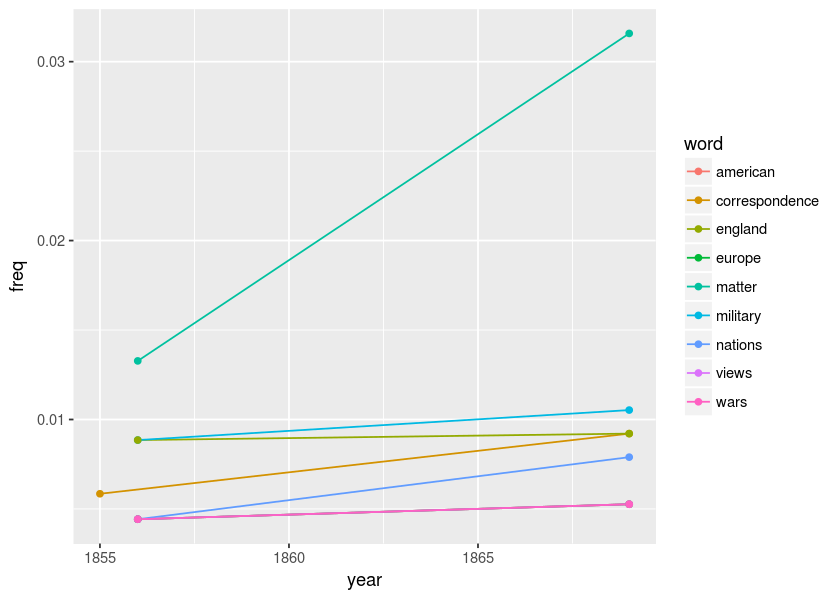

In [33]:
ggplot(title.words.adv.plot) +
    aes(x = year, y = freq, color = word) +
    geom_line() +
    geom_point()

We can see that during this break time, **_matter, nations, correspondence, military, american, europe, views, wars_** have greast increasing.

Let's look at year 1889 - 1922.

We are also focused on words having continously increasing for more than 5 years.

In [34]:
title.words.adv.fifth = monotonicIncrease(title.words.adv.freq, 1889, 1922, 5)
title.words.adv.fifth

name     word        freq_increase
1 AdvPeace arbitration 0.004636247  
2 AdvPeace front       0.015441871  
3 AdvPeace matter      0.030883742

Plot it

Joining, by = c("name", "word")


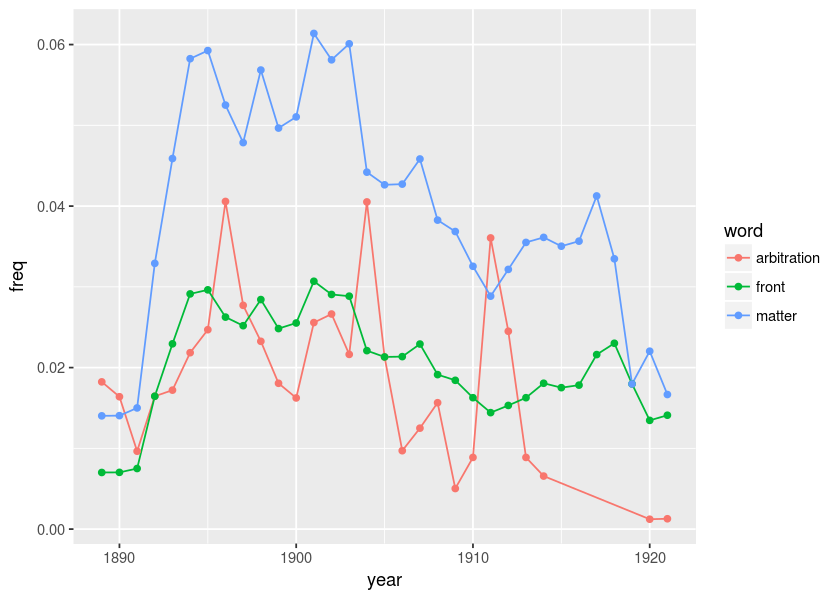

In [35]:
title.words.adv.freq %>% 
    filter(year >= 1889, year <= 1922) %>%
    inner_join(title.words.adv.fifth) %>%
    ggplot() +
    aes(x = year, y = freq, color = word) +
    geom_line() +
    geom_point()

We can see that from 1890 to 1895, **_arbitration, front, and matter_** have huge increasing.

Decrease the length of continuously increasing year to capture more short-term word frequency boosting. So we look at 3-year length.

Define two utility function to find words and corresponding monotonic periods:
- `word_Mono_Increase_Period` or `word_Mono_Decrease_Period` identify words with starting and ending year of continously increasing or decreasing
- `map_Word_To_Year` replicates each word to map it to each year between starting and ending year

In [36]:
word_Mono_Increase_Period = function(data, yearFrom, yearTo, period) {
    data %>%
        filter(year >= yearFrom, year <= yearTo) %>%
        group_by(name, word) %>%
        arrange(year) %>%
        mutate(continous_year = roll_sum(year_diff, period, fill = NA),
               continous_increase = roll_min(freq_diff, period, fill = NA)) %>%
        ungroup() %>%
        filter(continous_year==period, continous_increase > 0) %>%
        select(name, word, year) %>% 
        mutate(year_end = year + period-1)
}

In [37]:
word_Mono_Decrease_Period = function(data, yearFrom, yearTo, period) {
    data %>%
        filter(year >= yearFrom, year <= yearTo) %>%
        group_by(name, word) %>%
        arrange(year) %>%
        mutate(continous_year = roll_sum(year_diff, period, fill = NA),
               continous_increase = roll_max(freq_diff, period, fill = NA)) %>%
        ungroup() %>%
        filter(continous_year==period, continous_increase < 0) %>%
        select(name, word, year) %>% 
        mutate(year_end = year + period-1)
}

In [38]:
map_Word_To_Year = function(row, period) {
    year = row$year : row$year_end
    data.frame(word=c(row$word)) %>%
        slice(rep(1:n(), each = period)) %>%
        mutate(year = year)
}

Find words that monotonically increase at least for 3 years

In [39]:
title.words.adv.monoAsc = word_Mono_Increase_Period(title.words.adv.freq, 1889, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
title.words.adv.monoAsc

word    year
1   annual  1890
2   annual  1891
3   annual  1892
4   front   1890
5   front   1891
⋮   ⋮       ⋮   
163 league  1919
164 league  1920
165 nations 1918
166 nations 1919
167 nations 1920

Find top 10 words with the greatest increasing in monotonic periods

In [40]:
top10words = title.words.adv.freq %>%
    inner_join(title.words.adv.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10words

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name     word          freq_increase
1  AdvPeace peace         0.051646826  
2  AdvPeace matter        0.041327027  
3  AdvPeace notes         0.022126950  
4  AdvPeace front         0.021574865  
5  AdvPeace international 0.015045221  
6  AdvPeace arbitration   0.011254426  
7  AdvPeace fair          0.008256841  
8  AdvPeace american      0.008039175  
9  AdvPeace christian     0.007646200  
10 AdvPeace german        0.006437225

Plot it on its monotonical intervals by line

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


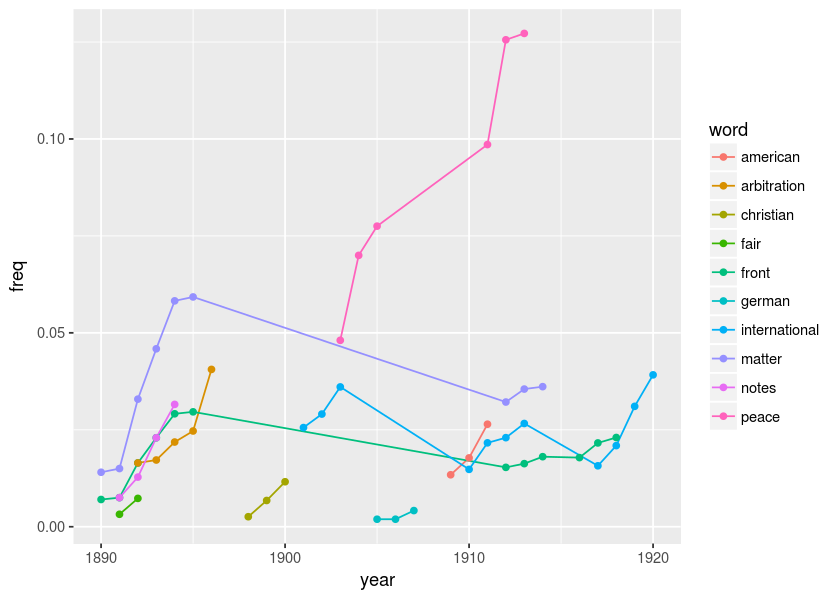

In [41]:
title.words.adv.monoAsc %>%
    inner_join(top10words %>% select(name, word)) %>%
    inner_join(title.words.adv.freq) %>%
    ggplot() +
    aes(x=year, y=freq, color=word) +
    geom_line() +
    geom_point()

bar plot

In [42]:
options(repr.plot.width=8,
        repr.plot.height=5)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


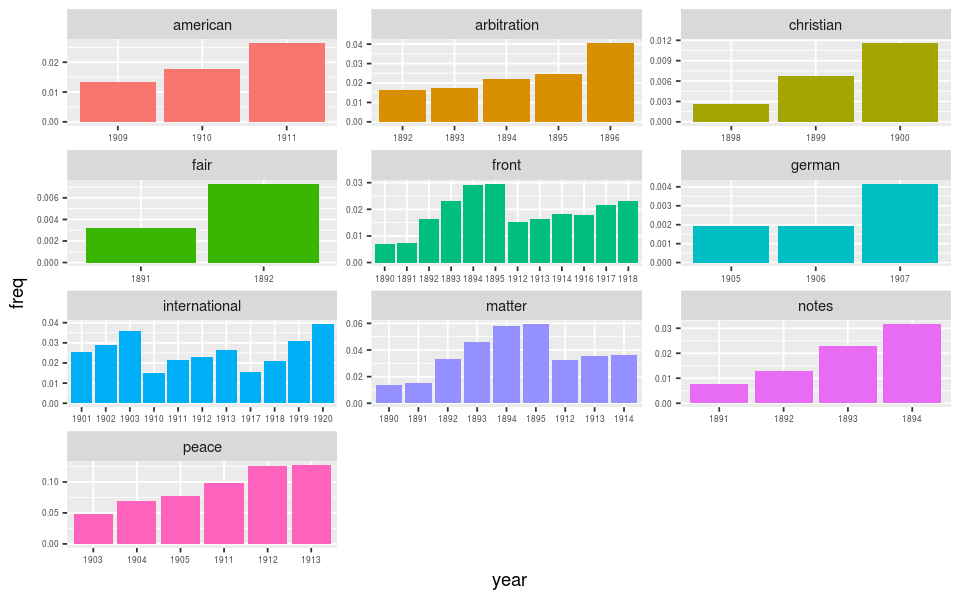

In [43]:
title.words.adv.monoAsc %>%
    inner_join(top10words %>% select(name, word)) %>%
    inner_join(title.words.adv.freq) %>%
    mutate(year=as.factor(year)) %>%
    ggplot() +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We can see that:
- 1890 - 1895, **_fair, arbitration, front, matter_, notes** have greatest increase.
- 1895 - 1900, **_christian_** has greatest increase.
- 1900 - 1920, **_international, peace, german, american_** are trending words.

Let's find words with continously decreasing trends

In [44]:
title.words.adv.monoDesc = word_Mono_Decrease_Period(title.words.adv.freq, 1889, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
title.words.adv.monoDesc %>% head(5)

word    year
1 america 1890
2 america 1891
3 america 1892
4 time    1890
5 time    1891

Top 10 greatest decresing words during its monotonical decreasing periods

In [45]:
top10words = title.words.adv.freq %>%
    inner_join(title.words.adv.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10words

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name     word          freq_decrease
1  AdvPeace peace         -0.101198814 
2  AdvPeace arbitration   -0.025410668 
3  AdvPeace notes         -0.022668146 
4  AdvPeace war           -0.014375528 
5  AdvPeace brevities     -0.013831280 
6  AdvPeace front         -0.011512966 
7  AdvPeace editorial     -0.011303430 
8  AdvPeace york          -0.010200333 
9  AdvPeace navy          -0.008662506 
10 AdvPeace international -0.008123767

Line plot

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


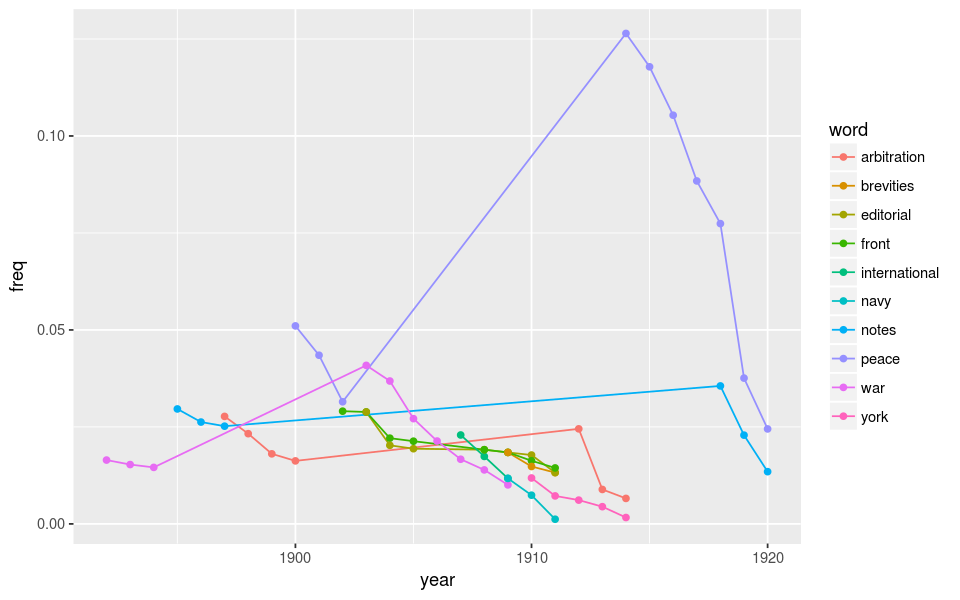

In [46]:
title.words.adv.monoDesc %>%
    inner_join(top10words %>% select(name, word)) %>%
    inner_join(title.words.adv.freq) %>%
    ggplot() +
    aes(x=year, y=freq, color=word) +
    geom_line() +
    geom_point() 

Bar plot

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


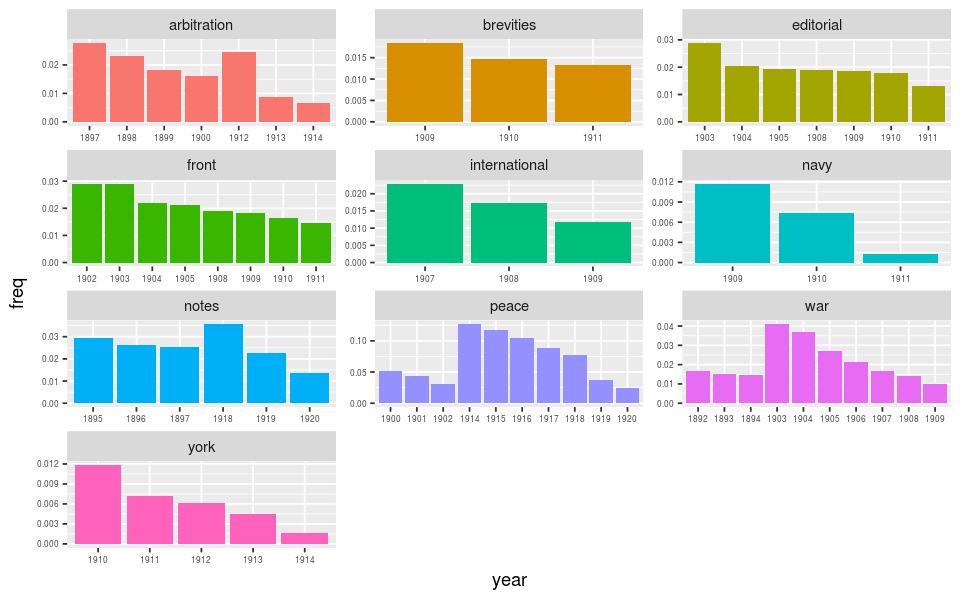

In [47]:
title.words.adv.monoDesc %>%
    inner_join(top10words %>% select(name, word)) %>%
    inner_join(title.words.adv.freq) %>%
    mutate(year=as.factor(year)) %>%
    ggplot() +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We can see that:
- 1892 - 1894 **_war_** is the greatest decreasing word.
- 1895 - 1900 **_notes_, _arbitration_** have the greatest decreasing.
- 1900 - 1910 **_editorial, front, peace, war, brevities, international, navy_**
- 1910 - 1920 **_york_, _peace_, _notes_, _arbitration_** have greatest decreasing.

We are going to use similar methods to analyze other journals.

Compute word count and frequency per year

In [48]:
title.words.stats = title.words.year %>%
    count(name, year, word) %>%
    ungroup() 
title.words.stats = title.words.stats %>%
    group_by(name, year) %>%
    summarize(count_year=sum(n)) %>%
    ungroup() %>%
    inner_join(title.words.stats) %>%
    mutate(freq = n / count_year)
title.words.stats %>% head(5)

Joining, by = c("name", "year")


name     year count_year word       n freq      
1 AdvPeace 1834 62         affairs    2 0.03225806
2 AdvPeace 1834 62         age        1 0.01612903
3 AdvPeace 1834 62         auxiliary  1 0.01612903
4 AdvPeace 1834 62         benevolent 1 0.01612903
5 AdvPeace 1834 62         condition  1 0.01612903

Check year range

In [49]:
title.words.stats %>%
    group_by(name) %>%
    summarize(start=min(year),
              end=max(year))

name      start end 
1 AdvPeace  1834  1922
2 AmPhil    1769  1920
3 AmRev     1815  1922
4 RoyalPhil 1665  1869
5 Science   1880  1922

Check missing year

In [50]:
missing.year = title.words.stats %>%
    select(name, year) %>%
    distinct() %>%
    group_by(name) %>%
    arrange(year) %>%
    mutate(pre_year = lag(year, default = min(year)),
           diff = year - pre_year) %>%
    filter(diff > 1) %>%
    ungroup() %>%
    arrange(name, year)

missing.year %>%
    select(name) %>%
    distinct()

name     
1 AdvPeace 
2 AmPhil   
3 RoyalPhil

_AdvPeace, AmPhil, RoyalPhil_ have missing years.

Check missing year gaps which are greater than 5 years

In [51]:
missing.year %>% filter(name == 'AmPhil', diff > 5)
missing.year %>% filter(name == 'RoyalPhil', diff > 5)

name   year pre_year diff
1 AmPhil 1786 1769     17  
2 AmPhil 1793 1786      7  
3 AmPhil 1799 1793      6  
4 AmPhil 1809 1802      7  
5 AmPhil 1818 1809      9  
6 AmPhil 1825 1818      7  
7 AmPhil 1853 1846      7  
8 AmPhil 1860 1853      7  
9 AmPhil 1881 1875      6

name      year pre_year diff
1 RoyalPhil 1683 1677     6   
2 RoyalPhil 1693 1686     7

We can see that for journal _AmPhil_, it rarely appears in continous years. So we just study words that appear (not continously) in at least 10 years.

**Article titles of journal AmPhil**

In [52]:
title.words.AmP = title.words.stats %>%
    filter(name == 'AmPhil') %>%
    count(name, word) %>%
    ungroup() %>%
    filter(nn > 10) %>%
    select(name, word)
# title.words.AmP

Join with `title.words.stats` to get frequency

In [53]:
title.words.Amp.freq = inner_join(title.words.stats, title.words.AmP) %>%
    select(name, word, year, freq) %>%
    group_by(name, word) %>%
    arrange(year) %>%
    mutate(freq_next = lead(freq),
           year_next = lead(year),
           freq_diff = freq_next - freq,
           year_diff = year_next - year) %>%
    ungroup() %>%
    drop_na() %>% # drop last year in which a word appears
    select(name, word, year, year_next, year_diff, freq, freq_next, freq_diff)
# title.words.Amp.freq

Joining, by = c("name", "word")


For each word, compute the frequency change from the year in which the word first appears to the year in which the word last appears.

Then find the top 10 increasing words and top 10 decreasing words

In [54]:
title.words.Amp.freq.diff = title.words.Amp.freq %>%
    group_by(name, word) %>%
    summarize(total_freq_diff = sum(freq_diff)) %>%
    ungroup()
top10IncreaseWords = title.words.Amp.freq.diff %>%
    top_n(10, total_freq_diff)
top10DecreaseWords = title.words.Amp.freq.diff %>%
    filter(total_freq_diff < 0) %>%
    top_n(10, -total_freq_diff)
top10IncreaseWords
top10DecreaseWords

name   word        total_freq_diff
1  AmPhil american    0.05586650     
2  AmPhil description 0.05752488     
3  AmPhil errata      0.05223881     
4  AmPhil front       0.14119877     
5  AmPhil information 0.07367104     
6  AmPhil matter      0.28405591     
7  AmPhil professor   0.05810440     
8  AmPhil society     0.05586650     
9  AmPhil species     0.05389718     
10 AmPhil volume      0.07041901

name   word         total_freq_diff
1 AmPhil account      -0.018614791   
2 AmPhil communicated -0.019875622   
3 AmPhil letter       -0.004485768

Join these words with `title.words.Amp.freq` to get frequency and plot it

In [55]:
title.top10.increase.plot = top10IncreaseWords %>%
    inner_join(title.words.Amp.freq) %>%
    select(name, word, year, freq)
title.top10.decrease.plot = top10DecreaseWords %>%
    inner_join(title.words.Amp.freq) %>%
    select(name, word, year, freq)

Joining, by = c("name", "word")
Joining, by = c("name", "word")


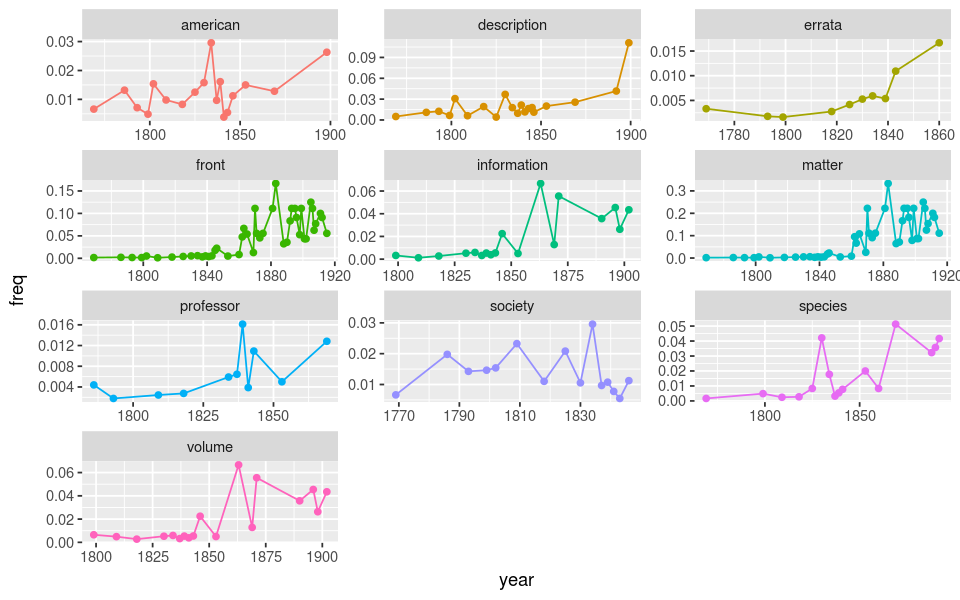

In [56]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

We see that:
- 1820 - 1850, **_american, errata, professor, species_** increase quickly
- 1850 - 1920, **_american, description, front, information, matter, species, volume_** increase quickly

In [58]:
options(repr.plot.height=3.5,
        repr.plot.width=6)

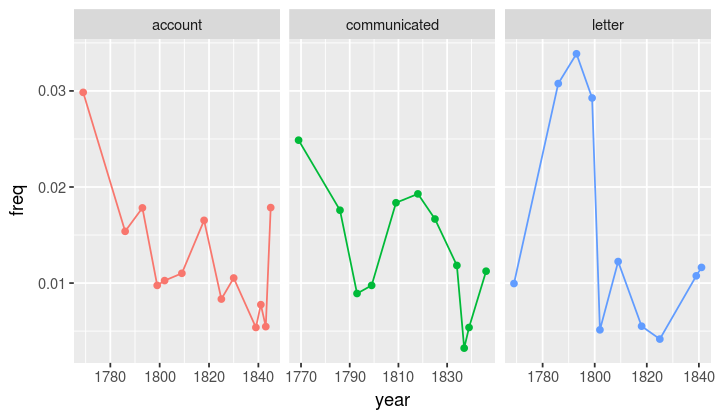

In [59]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free_x', ncol = 3) +
    theme(legend.position = 'none')

We see that:
- 1770 - 1800, **_account, communicated_** decrease quickly
- 1790 - 1810, **_letter_** decrease quickly
- 1820 - 1835, this is another period for these three words experiencing quick decrement.

So now we are going to look at other journals which have words appear in continous years.

Let's compute frequency difference and year difference dataframe for all journals

In [60]:
title.words.freq = title.words.stats %>%
    select(name, word, year, freq) %>%
    group_by(name, word) %>%
    arrange(year) %>%
    mutate(freq_next = lead(freq),
           year_next = lead(year),
           freq_diff = freq_next - freq,
           year_diff = year_next - year) %>%
    ungroup() %>%
    drop_na() %>% # drop last year in which a word appears
    select(name, word, year, year_next, year_diff, freq, freq_next, freq_diff)
title.words.freq %>% head()

name      word year year_next year_diff freq         freq_next  
1 RoyalPhil 1666 1665 1666      1         0.0029126214 0.001727116
2 RoyalPhil 18   1665 1668      3         0.0009708738 0.003030303
3 RoyalPhil 20   1665 1669      4         0.0019417476 0.001307190
4 RoyalPhil 22   1665 1670      5         0.0009708738 0.002317497
5 RoyalPhil 24   1665 1671      6         0.0009708738 0.001109878
6 RoyalPhil 28   1665 1671      6         0.0009708738 0.001109878
  freq_diff    
1 -0.0011855056
2  0.0020594292
3 -0.0006345580
4  0.0013466233
5  0.0001390041
6  0.0001390041

**Article titles of journal RoyalPhil**

We are going to look at two periods: 1665 - 1677, 1693 - 1869, since during these two periods, we have words continously show up.

Filter _RoyalPhil_ data

In [61]:
title.words.RP.freq = title.words.freq %>%
    filter(name == 'RoyalPhil')

Find words that monotonically increase or decrease for at least 3 years during 1665 - 1677

In [62]:
title.words.RP.monoAsc = word_Mono_Increase_Period(title.words.RP.freq, 1665, 1677, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.RP.monoAsc

title.words.RP.monoDesc = word_Mono_Decrease_Period(title.words.RP.freq, 1665, 1677, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.RP.monoDesc

In [63]:
top10IncreaseWords = title.words.RP.freq %>%
    inner_join(title.words.RP.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = title.words.RP.freq %>%
    inner_join(title.words.RP.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name      word         freq_increase
1  RoyalPhil observations 0.012070538  
2  RoyalPhil letter       0.008278172  
3  RoyalPhil account      0.006409576  
4  RoyalPhil flamstead    0.002853459  
5  RoyalPhil animals      0.002673797  
6  RoyalPhil person       0.002673797  
7  RoyalPhil de           0.001775262  
8  RoyalPhil theory       0.001604396  
9  RoyalPhil late         0.001574322  
10 RoyalPhil observed     0.001129022

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name      word         freq_decrease
1  RoyalPhil communicated -3.771875e-03
2  RoyalPhil sea          -1.970222e-03
3  RoyalPhil account      -1.506110e-03
4  RoyalPhil john         -9.828581e-04
5  RoyalPhil ingenious    -9.121431e-04
6  RoyalPhil front        -2.841716e-05
7  RoyalPhil inquisitive  -2.841716e-05
8  RoyalPhil wallis        1.221938e-03
9  RoyalPhil experiment    2.529128e-03
10 RoyalPhil answer        5.058255e-03

Join with frequency and plot

In [64]:
title.top10.increase.plot = title.words.RP.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(title.words.stats %>%
        select(name, word, year, freq))

title.top10.decrease.plot = title.words.RP.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(title.words.stats %>%
        select(name, word, year, freq)) 

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


In [67]:
options(repr.plot.height=5,
        repr.plot.width=8)

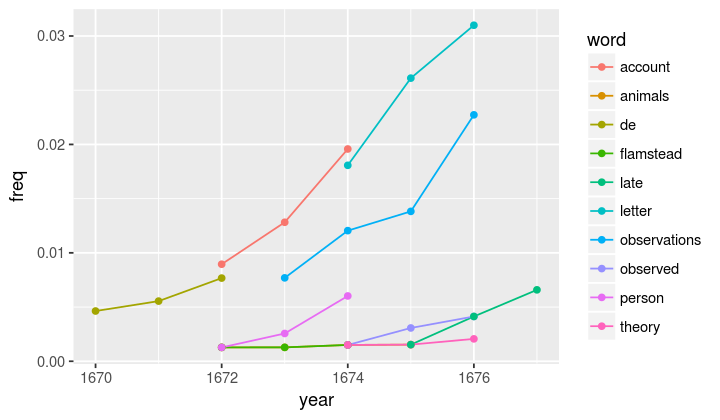

In [65]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

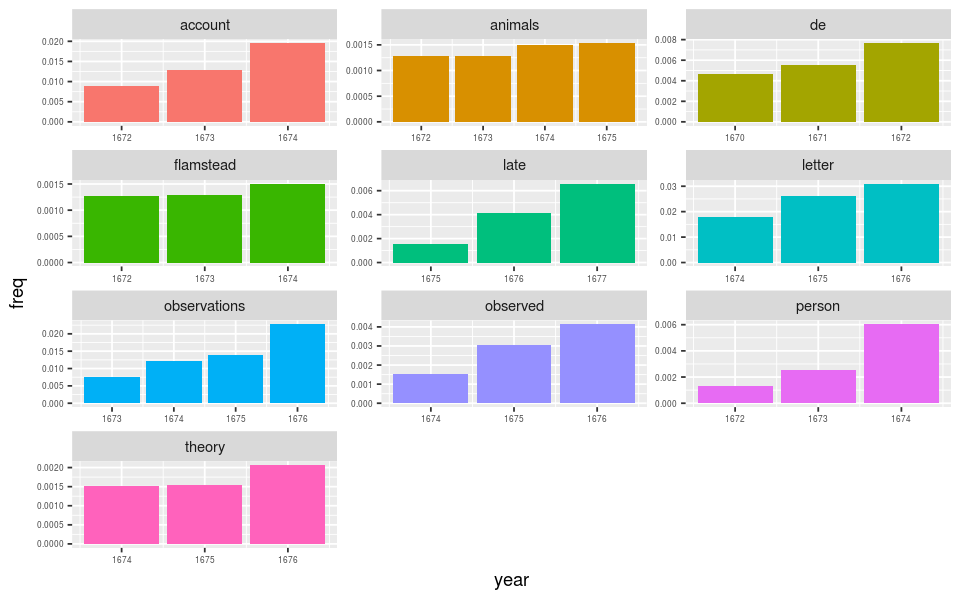

In [68]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that:
- 1670 - 1672, **_de_** increase quickly
- 1672 - 1675, **_account, animals, flamstead, observations, person_** increase quickly
- 1675 - 1677, **_late, letter, observed, theory_** increase quickly

Now look at decreasing trends.

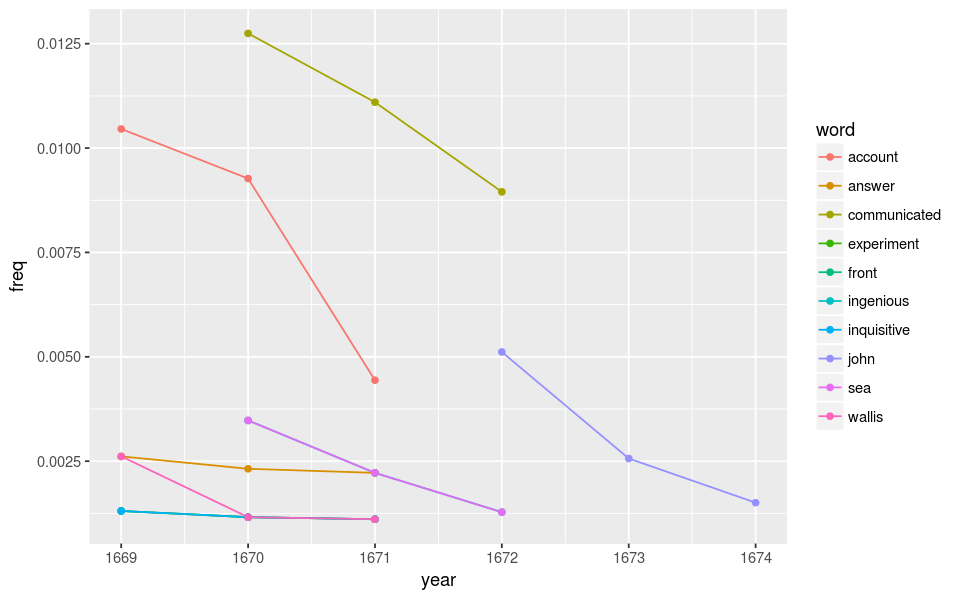

In [69]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

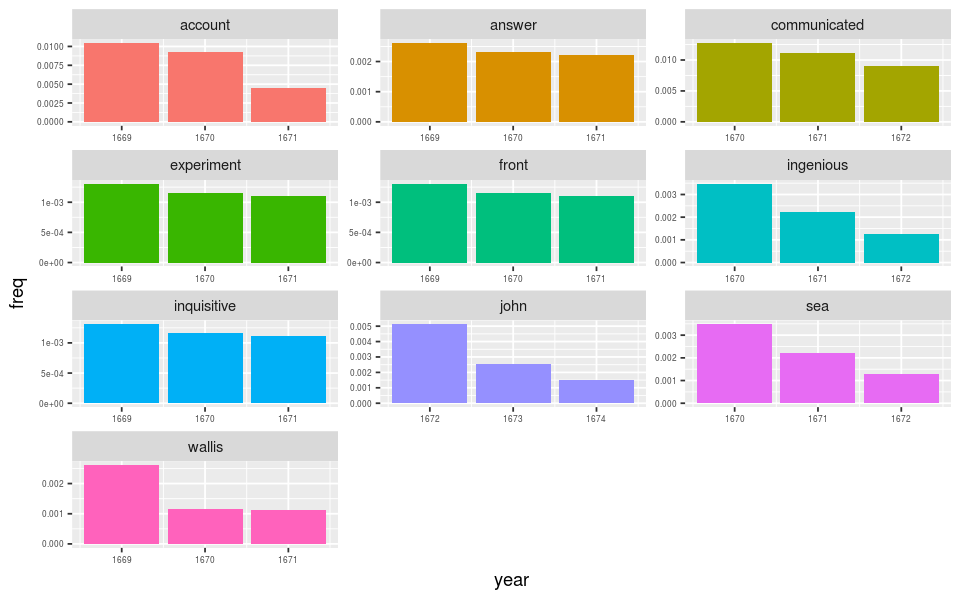

In [70]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that:
- 1669 - 1672, **_account, answer, communicated, experiment, front, ingenious, inquisitive, sea, wallis_** decrease quickly
- 1672 - 1675, **_john_** decrease quickly

**For year 1693 - 1869**

In [71]:
title.words.RP.monoAsc = word_Mono_Increase_Period(title.words.RP.freq, 1693, 1869, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.RP.monoAsc

title.words.RP.monoDesc = word_Mono_Decrease_Period(title.words.RP.freq, 1693, 1869, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.RP.monoDesc

In [72]:
top10IncreaseWords = title.words.RP.freq %>%
    inner_join(title.words.RP.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = title.words.RP.freq %>%
    inner_join(title.words.RP.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name      word           freq_increase
1  RoyalPhil researches     0.034197472  
2  RoyalPhil banks          0.015712868  
3  RoyalPhil royal          0.015408177  
4  RoyalPhil magnetic       0.014381244  
5  RoyalPhil john           0.012215836  
6  RoyalPhil communicated   0.010881436  
7  RoyalPhil matter         0.009631098  
8  RoyalPhil bart           0.009163258  
9  RoyalPhil experiments    0.008767266  
10 RoyalPhil meteorological 0.006958033

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name      word           freq_decrease
1  RoyalPhil magnetic       -0.021128083 
2  RoyalPhil communicated   -0.016285870 
3  RoyalPhil john           -0.014791255 
4  RoyalPhil account        -0.014751944 
5  RoyalPhil society        -0.011773113 
6  RoyalPhil george         -0.011627907 
7  RoyalPhil 1769           -0.011553258 
8  RoyalPhil experiments    -0.009645694 
9  RoyalPhil action         -0.009353479 
10 RoyalPhil meteorological -0.008840047

Join with frequency and plot

In [73]:
title.top10.increase.plot = title.words.RP.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(title.words.RP.freq)

title.top10.decrease.plot = title.words.RP.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(title.words.RP.freq) 

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


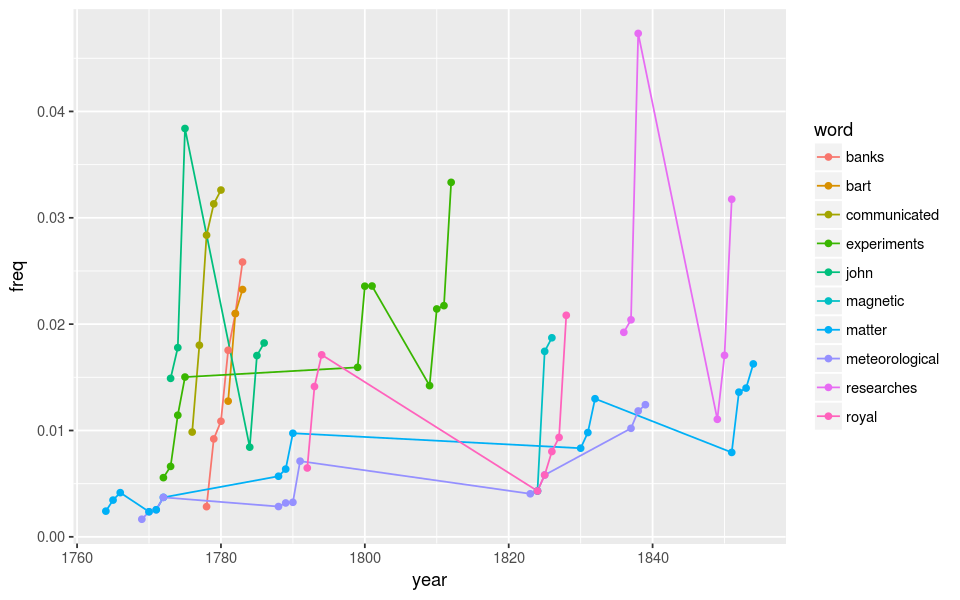

In [74]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

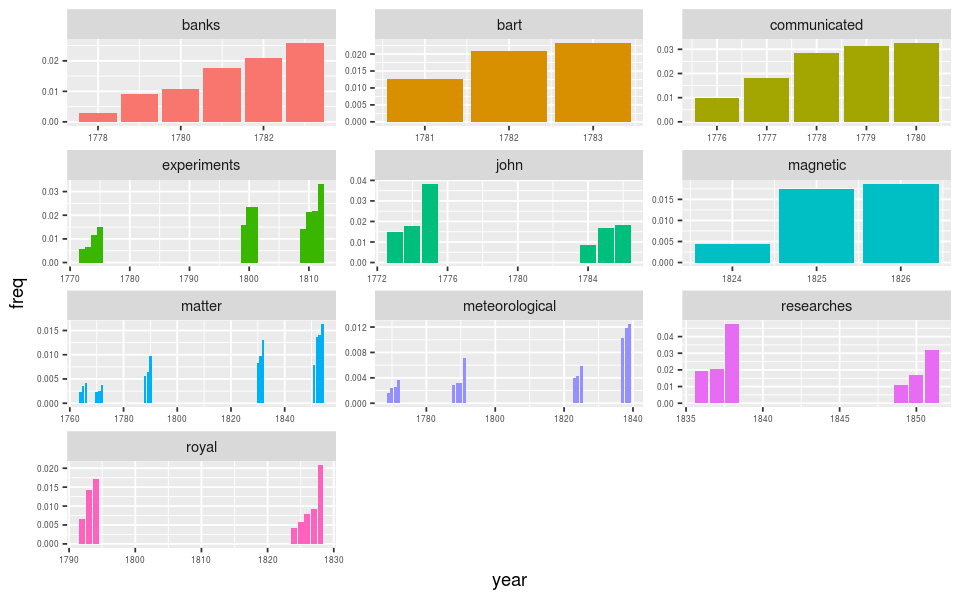

In [75]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that:
- 1760 - 1770, **_matter_** increase quickly
- 1770 - 1780, **_banks, communicated, experiments, john, matter, meteorological_** increase quickly
- 1780 - 1790, **_bart, john, matter, meteorological_** increase quickly
- 1790 - 1800, **_royal_** increase quickly
- 1800 - 1820, **_experiments_** increase quickly
- 1820 - 1850, **_magnetic, matter, meteorological, researches, royal_** increase quickly

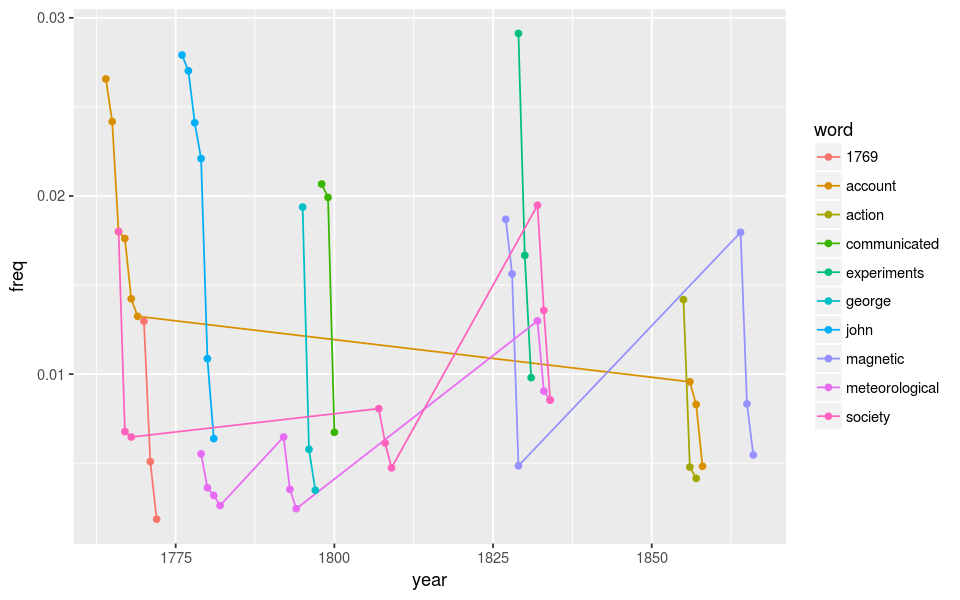

In [76]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

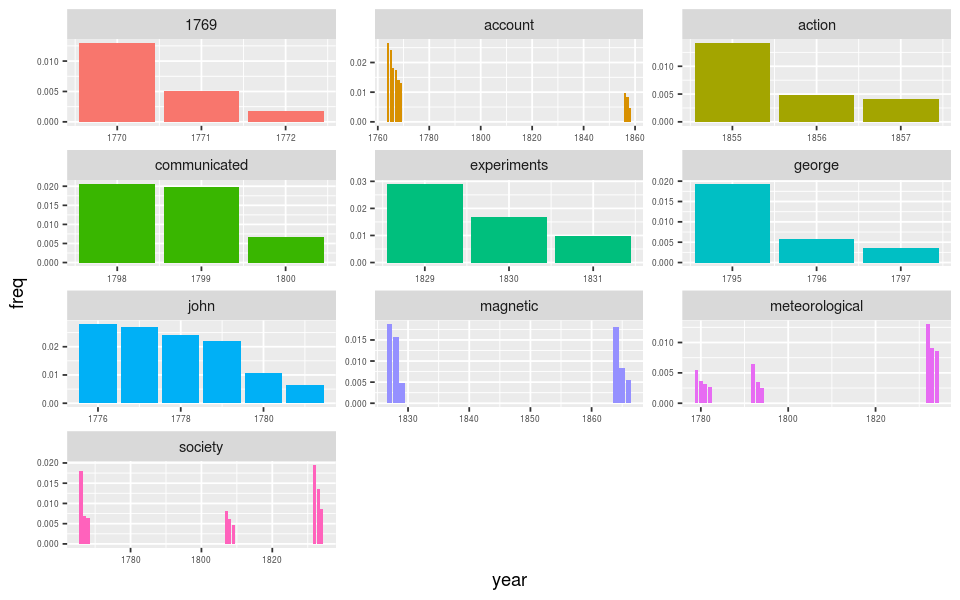

In [77]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that words that decrease quickly are:
- 1760 - 1770, **_account, society_**
- 1770 - 1780, **_1769, john_** 
- 1780 - 1790, **_meteorological_**
- 1790 - 1800, **_communicated, george, meteorological_**
- 1800 - 1820, **_society_**
- 1820 - 1850, **_magnetic, experiments, meteorological, society_**
- 1850 - 1870, **_magnetic, action, account_**

**Article titles of journal AmRev**

We are going to look at two periods: 1815 - 1922

Filter _AmRev_ data

In [78]:
title.words.freq.journal = title.words.freq %>%
    filter(name == 'AmRev')

Find words that monotonically increase or decrease for at least 3 years

In [80]:
title.words.monoAsc = word_Mono_Increase_Period(title.words.freq.journal, 1815, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.monoAsc

title.words.monoDesc = word_Mono_Decrease_Period(title.words.freq.journal, 1815, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [81]:
top10IncreaseWords = title.words.freq.journal %>%
    inner_join(title.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = title.words.freq.journal %>%
    inner_join(title.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name  word         freq_increase
1  AmRev volume       0.205485100  
2  AmRev information  0.203264233  
3  AmRev matter       0.109682188  
4  AmRev united       0.026820834  
5  AmRev publications 0.022573182  
6  AmRev world        0.020488334  
7  AmRev politics     0.019910826  
8  AmRev month        0.009939564  
9  AmRev travels      0.008536585  
10 AmRev letters      0.006432935

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name  word         freq_decrease
1  AmRev information  -0.07515216  
2  AmRev volume       -0.07390372  
3  AmRev matter       -0.05639928  
4  AmRev north        -0.04284097  
5  AmRev journal      -0.03746898  
6  AmRev publications -0.03384237  
7  AmRev list         -0.02469355  
8  AmRev politics     -0.02156518  
9  AmRev books        -0.01593018  
10 AmRev petersburg   -0.01375441

Join with frequency and plot

In [82]:
title.top10.increase.plot = title.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(title.words.stats)

title.top10.decrease.plot = title.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(title.words.stats) 

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


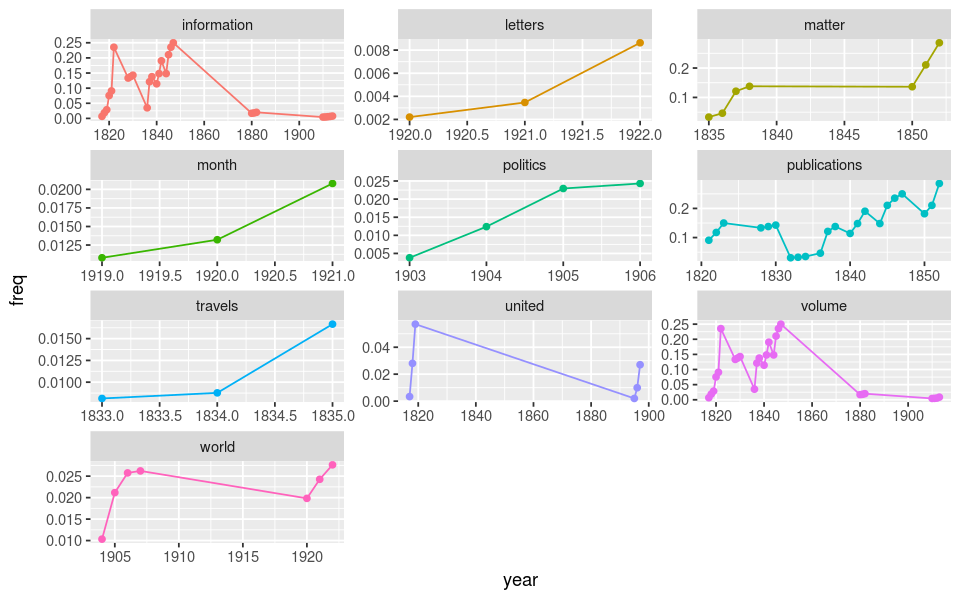

In [83]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

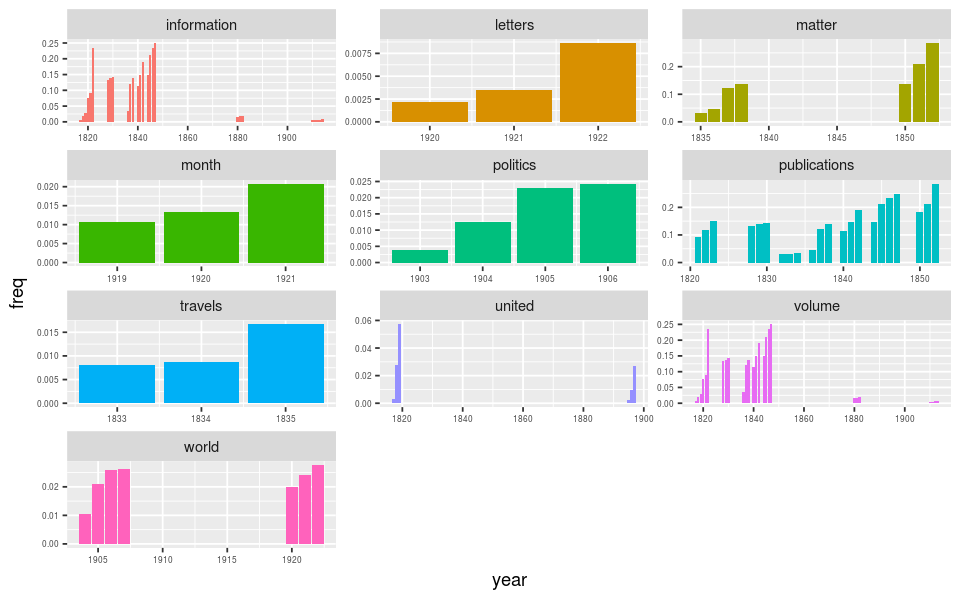

In [84]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that words that increase quickly are:
- 1820 - 1830, **_information, publications, united, volume_**
- 1830 - 1840, **_information, matter, volume_**
- 1840 - 1850, **_information_**
- 1850 - 1860, **_matter, publications_**
- 1880 - 1900, **_information, united, volume_**
- 1900 - 1920, **_information, month, politics, volume_**
- 1920 - 1930, **_letters, world_**

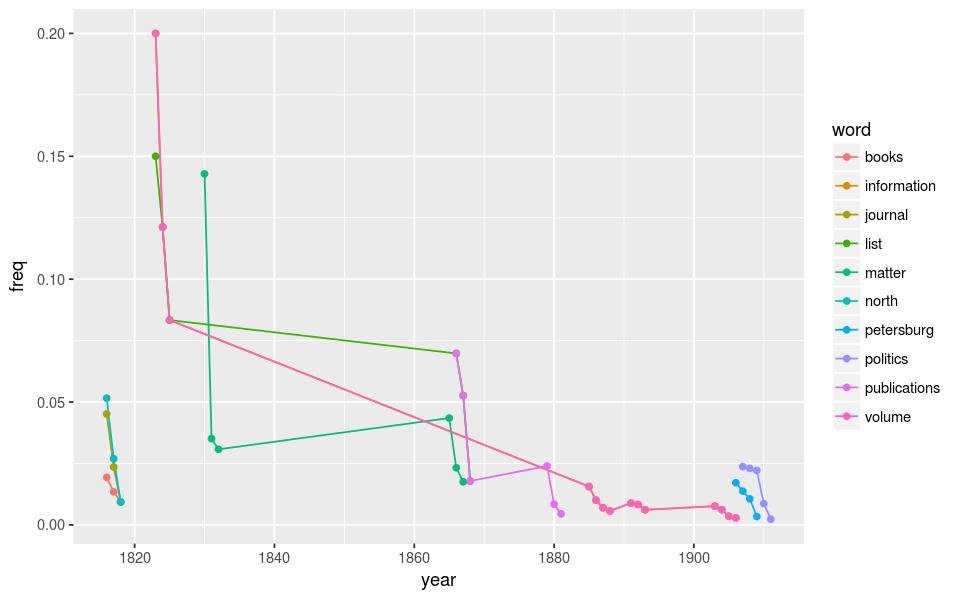

In [85]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

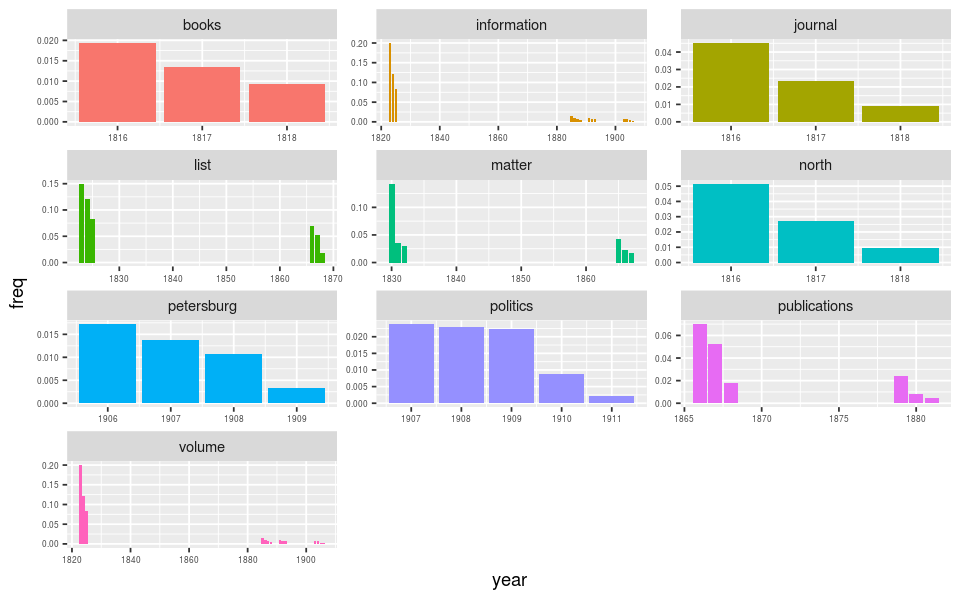

In [86]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that words that decrease quickly are:
- 1815 - 1820, **_books, journal, north_**
- 1820 - 1830, **_information, list, volume_**
- 1830 - 1840, **_matter_**
- 1865 - 1870, **_list, matter, publications_**
- 1880 - 1900, **_information, volume_**
- 1900 - 1910, **_information, petersburg, politics, volume_**

**Article titles of journal Science**

We are going to look at period: 1880 - 1922

Filter _Science_ data

In [87]:
title.words.freq.journal = title.words.freq %>%
    filter(name == 'Science')

Find words that monotonically increase or decrease for at least 3 years

In [88]:
title.words.monoAsc = word_Mono_Increase_Period(title.words.freq.journal, 1880, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.monoAsc

title.words.monoDesc = word_Mono_Decrease_Period(title.words.freq.journal, 1880, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# title.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [89]:
top10IncreaseWords = title.words.freq.journal %>%
    inner_join(title.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = title.words.freq.journal %>%
    inner_join(title.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name    word          freq_increase
1  Science matter        0.049069903  
2  Science news          0.026245876  
3  Science health        0.019757880  
4  Science current       0.018284401  
5  Science front         0.011724548  
6  Science war           0.007167964  
7  Science science       0.006270284  
8  Science international 0.005882641  
9  Science chemistry     0.005739561  
10 Science notes         0.004955918

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name    word       freq_decrease
1  Science notes      -0.03919963  
2  Science news       -0.03435851  
3  Science publishers -0.03411256  
4  Science electrical -0.01531426  
5  Science recent     -0.01528373  
6  Science editorial  -0.01515564  
7  Science academies  -0.01460739  
8  Science books      -0.01432124  
9  Science societies  -0.01391958  
10 Science york       -0.01176121

Join with frequency and plot

In [90]:
title.top10.increase.plot = title.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(title.words.stats)

title.top10.decrease.plot = title.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(title.words.stats) 

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


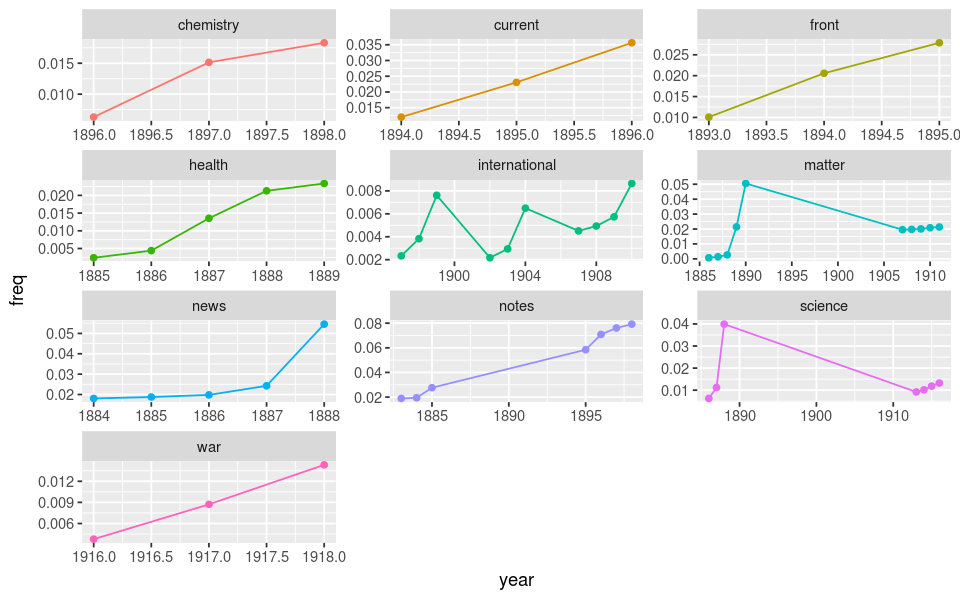

In [91]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

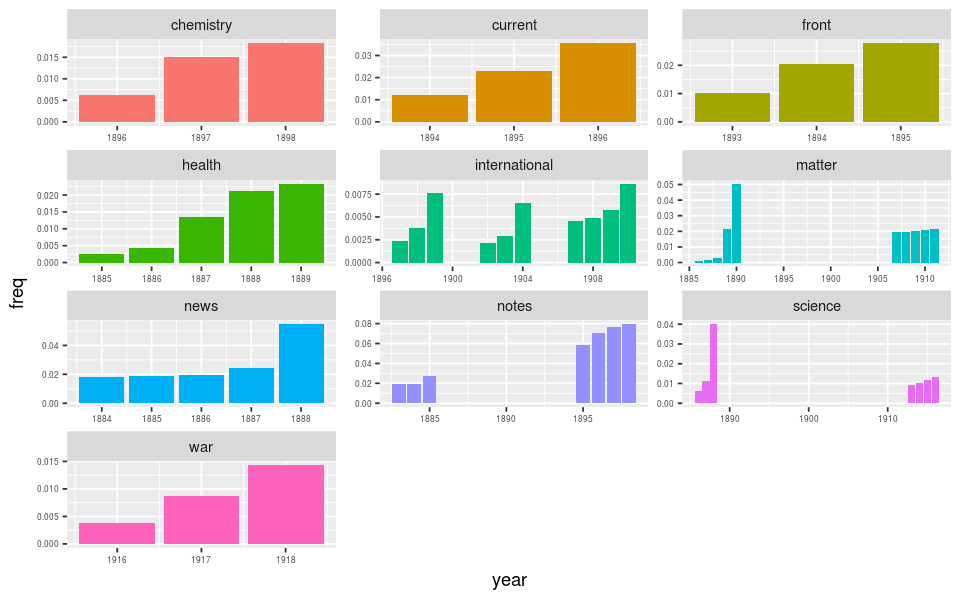

In [92]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

**Science**

We see that words that increase quickly are:
- 1880 - 1890, **_chemistry, health, matter, news, notes, science_**
- 1890 - 1900, **_current, front, international, notes_**
- 1900 - 1910, **_international, matter_**
- 1910 - 1920, **_war, science_**

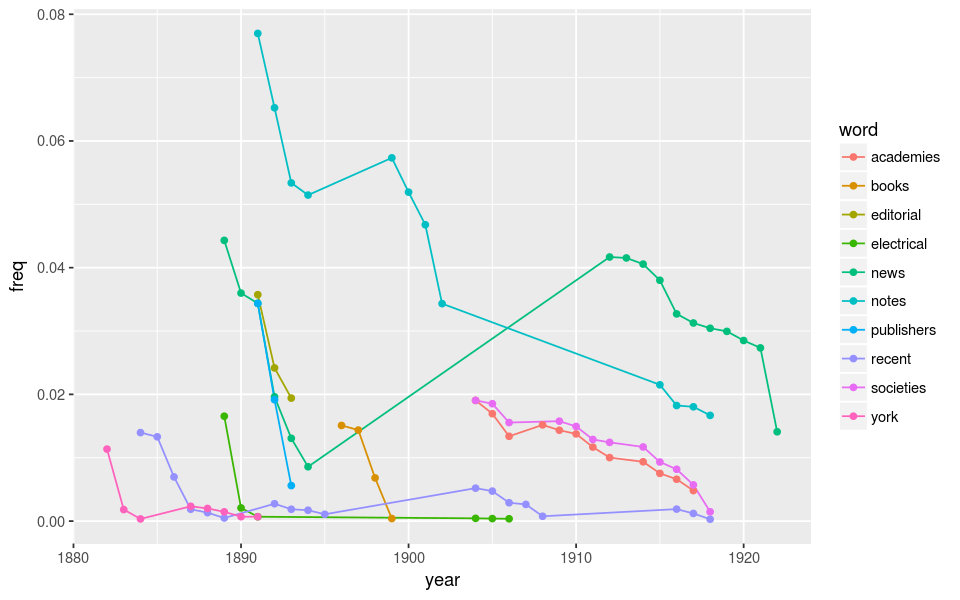

In [93]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

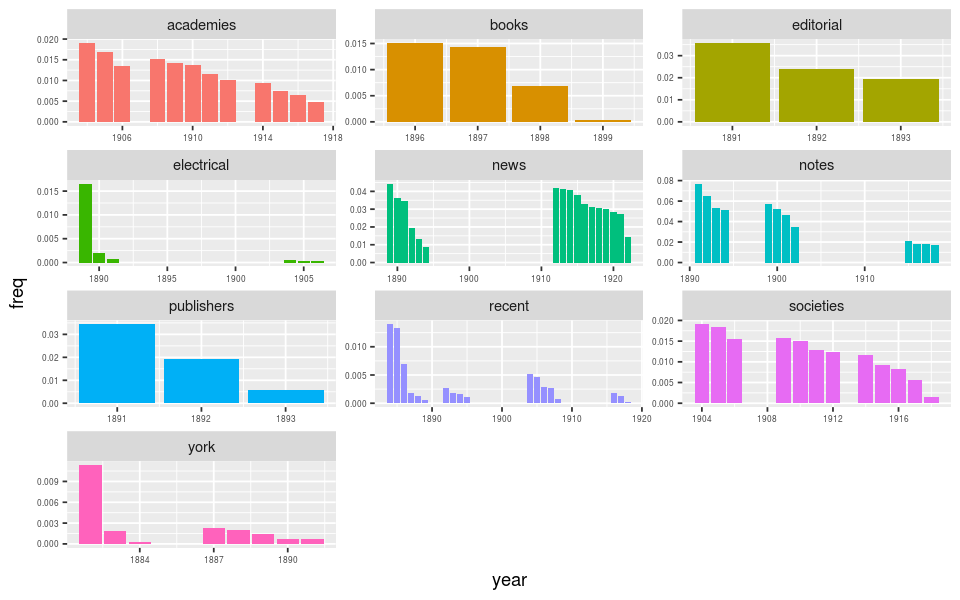

In [94]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that words that decrease quickly are:
- 1880 - 1890, **_recent, york_**
- 1890 - 1900, **_academies, books, editorial, electrical, news, notes, publishers, recent, york_**
- 1900 - 1910, **_electrical, notes, recent, societies_**
- 1910 - 1920, **_academies, news, notes, recent, societies_**

Let's look at title words that are the most consistently frequently used.

To simplify this question, we are going to look at title words that are the most frequently shown on the "Top-20" List of word frequency on every year.
- group by journal and year, compute top 20 list for every year based on frequency
- group by journal and word, compute times of words on top 20 list

In [95]:
title.words.frequently.used = title.words.stats %>%
    select(name, year, word, freq) %>%
    group_by(name, year) %>%
    top_n(20, freq) %>%
    ungroup() %>%
    group_by(name, word) %>%
    summarize(countsOnTopList = n()) %>%
    top_n(10, countsOnTopList)

**Journal AdvPeace**

In [96]:
title.words.frequently.used %>%
    filter(name == 'AdvPeace') %>%
    arrange(-countsOnTopList)

name     word          countsOnTopList
1  AdvPeace peace         57             
2  AdvPeace war           56             
3  AdvPeace matter        55             
4  AdvPeace society       47             
5  AdvPeace american      46             
6  AdvPeace front         42             
7  AdvPeace international 37             
8  AdvPeace annual        32             
9  AdvPeace congress      32             
10 AdvPeace notes         32

**Journal AmPhil**

In [97]:
title.words.frequently.used %>%
    filter(name == 'AmPhil') %>%
    arrange(-countsOnTopList)

name   word         countsOnTopList
1  AmPhil front        32             
2  AmPhil matter       32             
3  AmPhil observations 19             
4  AmPhil description  18             
5  AmPhil american     15             
⋮  ⋮      ⋮            ⋮              
7  AmPhil united       15             
8  AmPhil society      14             
9  AmPhil account      12             
10 AmPhil species      11             
11 AmPhil volume       11

**Journal AmRev**

In [98]:
title.words.frequently.used %>%
    filter(name == 'AmRev') %>%
    arrange(-countsOnTopList)

name  word         countsOnTopList
1  AmRev volume       90             
2  AmRev information  89             
3  AmRev american     56             
4  AmRev publications 56             
5  AmRev matter       49             
6  AmRev front        46             
7  AmRev ii           34             
8  AmRev list         32             
9  AmRev united       32             
10 AmRev america      29

**Journal RoyalPhil**

In [99]:
title.words.frequently.used %>%
    filter(name == 'RoyalPhil') %>%
    arrange(-countsOnTopList)

name      word         countsOnTopList
1  RoyalPhil observations 143            
2  RoyalPhil account      139            
3  RoyalPhil royal        102            
4  RoyalPhil letter        95            
5  RoyalPhil experiments   84            
6  RoyalPhil communicated  83            
7  RoyalPhil society       81            
8  RoyalPhil matter        77            
9  RoyalPhil john          70            
10 RoyalPhil dr            67

**Journal Science**

In [100]:
title.words.frequently.used %>%
    filter(name == 'Science') %>%
    arrange(-countsOnTopList)

name    word        countsOnTopList
1  Science american    43             
2  Science notes       43             
3  Science news        40             
4  Science science     40             
5  Science matter      36             
6  Science front       34             
7  Science scientific  34             
8  Science association 30             
9  Science society     30             
10 Science university  30

Plot it top 5 words

In [101]:
options(repr.plot.height = 10)

Joining, by = c("name", "word")


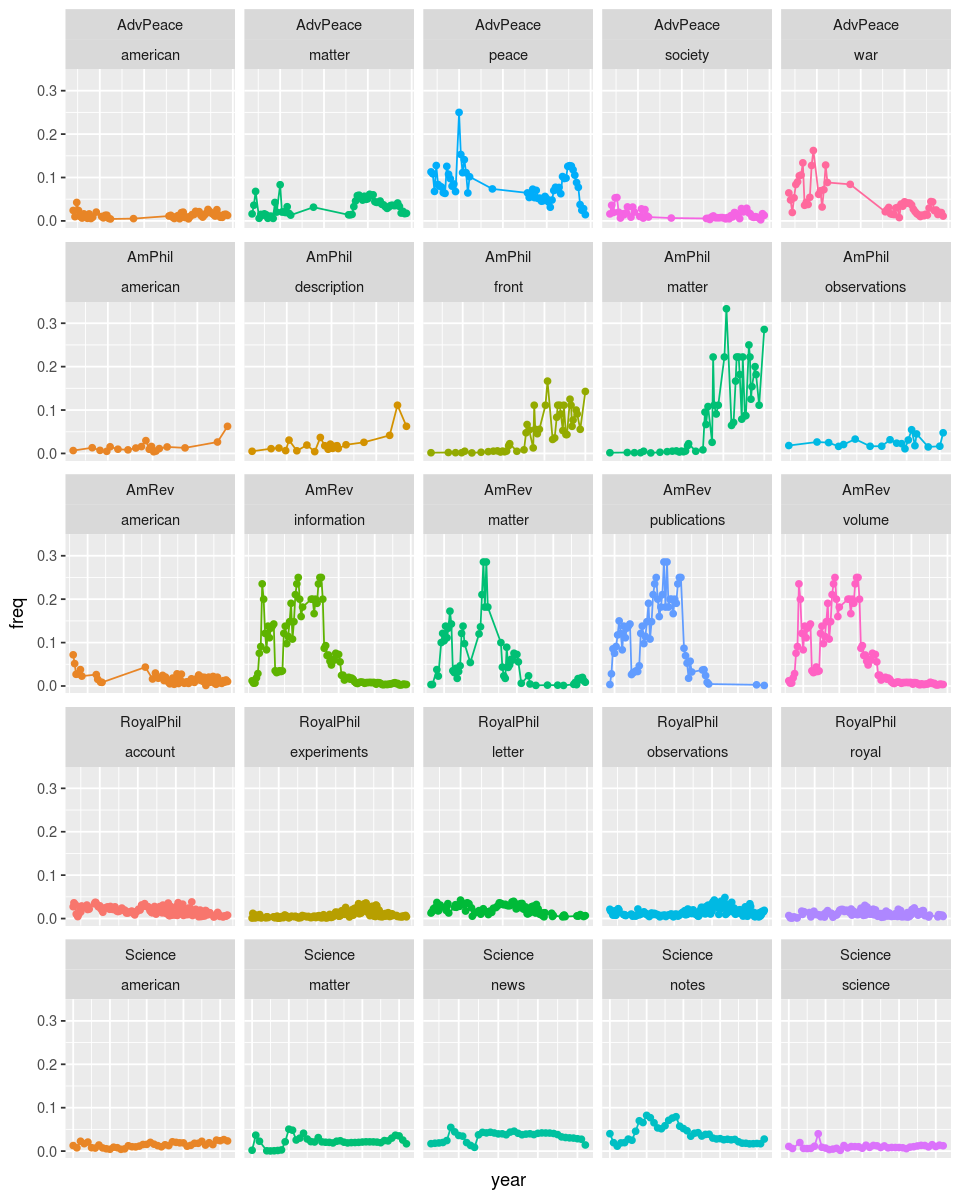

In [102]:
title.words.stats %>%
    inner_join(title.words.frequently.used %>%
    group_by(name) %>%
    arrange(-countsOnTopList) %>%
    mutate(rank = row_number()) %>%
    ungroup() %>%
    filter(rank < 6)) %>%
    ggplot() +
    aes(x = year, y = freq, color=word) +
    geom_line() +
    geom_point() +
    facet_wrap(name~word, ncol = 5, scales = 'free_x') +
    theme(legend.position = 'none',
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

**Analysis of title words for all journals**

Now let's do the same analysis for all journals

In [103]:
title.words.year.all = title.words.stats %>%
    select(name, year, count_year) %>%
    distinct() %>%
    group_by(year) %>%
    summarize(count_year = sum(count_year)) %>%
    ungroup()

title.words.all.stats = title.words.stats %>%
    group_by(year, word) %>%
    summarize(n = sum(n)) %>%
    ungroup() %>% 
    inner_join(title.words.year.all) %>%
    mutate(freq = n / count_year,
           name = "allJournals") %>%
    select(name, year, count_year, word, n, freq)
title.words.all.stats %>% head()

Joining, by = "year"


name        year count_year word n freq        
1 allJournals 1665 1030       1665 1 0.0009708738
2 allJournals 1665 1030       1666 3 0.0029126214
3 allJournals 1665 1030       18   1 0.0009708738
4 allJournals 1665 1030       20   2 0.0019417476
5 allJournals 1665 1030       22   1 0.0009708738
6 allJournals 1665 1030       24   1 0.0009708738

Check year range

In [104]:
title.words.all.stats %>%
    group_by(name) %>%
    summarize(start=min(year),
              end=max(year))

name        start end 
1 allJournals 1665  1922

We can write an utility function to convert one dataframe to the one we want

In [105]:
statsToFreq = function(wordStats) {
    wordStats %>%
        select(name, word, year, freq) %>%
        group_by(name, word) %>%
        arrange(year) %>%
        mutate(freq_next = lead(freq),
               year_next = lead(year),
               freq_diff = freq_next - freq,
               year_diff = year_next - year) %>%
        ungroup() %>%
        drop_na() %>% # drop last year in which a word appears
        select(name, word, year, year_next, year_diff, freq, freq_next, freq_diff)
}

In [106]:
title.words.all.freq = statsToFreq(title.words.all.stats)
title.words.all.freq %>% head()

name        word year year_next year_diff freq         freq_next   
1 allJournals 1665 1665 1887      222       0.0009708738 0.0003684598
2 allJournals 1666 1665 1666        1       0.0029126214 0.0017271157
3 allJournals 18   1665 1668        3       0.0009708738 0.0030303030
4 allJournals 20   1665 1669        4       0.0019417476 0.0013071895
5 allJournals 22   1665 1670        5       0.0009708738 0.0023174971
6 allJournals 24   1665 1671        6       0.0009708738 0.0011098779
  freq_diff    
1 -0.0006024139
2 -0.0011855056
3  0.0020594292
4 -0.0006345580
5  0.0013466233
6  0.0001390041

Find words that monotonically increase or decrease for at least 4 years

In [107]:
title.words.monoAsc = word_Mono_Increase_Period(title.words.all.freq, 1665, 1922, 4) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 4) %>%
    select(word, year) %>%
    distinct()
# title.words.monoAsc

title.words.monoDesc = word_Mono_Decrease_Period(title.words.all.freq, 1665, 1922, 4) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 4) %>%
    select(word, year) %>%
    distinct()
# title.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [108]:
top10IncreaseWords = title.words.all.freq %>%
    inner_join(title.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = title.words.all.freq %>%
    inner_join(title.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name        word         freq_increase
1  allJournals matter       0.089153804  
2  allJournals banks        0.015712868  
3  allJournals experiments  0.015698222  
4  allJournals front        0.014153699  
5  allJournals observations 0.012070538  
6  allJournals health       0.011082833  
7  allJournals communicated 0.010881436  
8  allJournals news         0.010754997  
9  allJournals information  0.009525625  
10 allJournals chemistry    0.007308541

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name        word      freq_decrease
1  allJournals peace     -0.019631561 
2  allJournals editorial -0.016075549 
3  allJournals john      -0.014883272 
4  allJournals recent    -0.013768845 
5  allJournals notes     -0.011163019 
6  allJournals books     -0.010540231 
7  allJournals matter    -0.009933739 
8  allJournals academies -0.008462199 
9  allJournals societies -0.008313251 
10 allJournals inorganic -0.007901887

Join with frequency and plot

In [109]:
title.top10.increase.plot = title.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(title.words.all.stats)

title.top10.decrease.plot = title.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(title.words.all.stats) 

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


In [113]:
options(repr.plot.height=5,
        repr.plot.width=8)

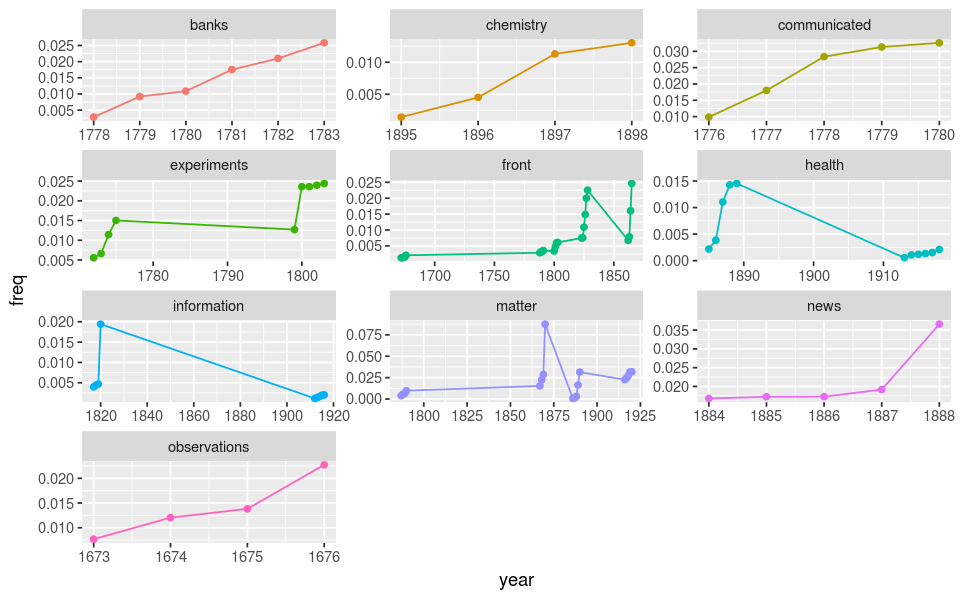

In [114]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

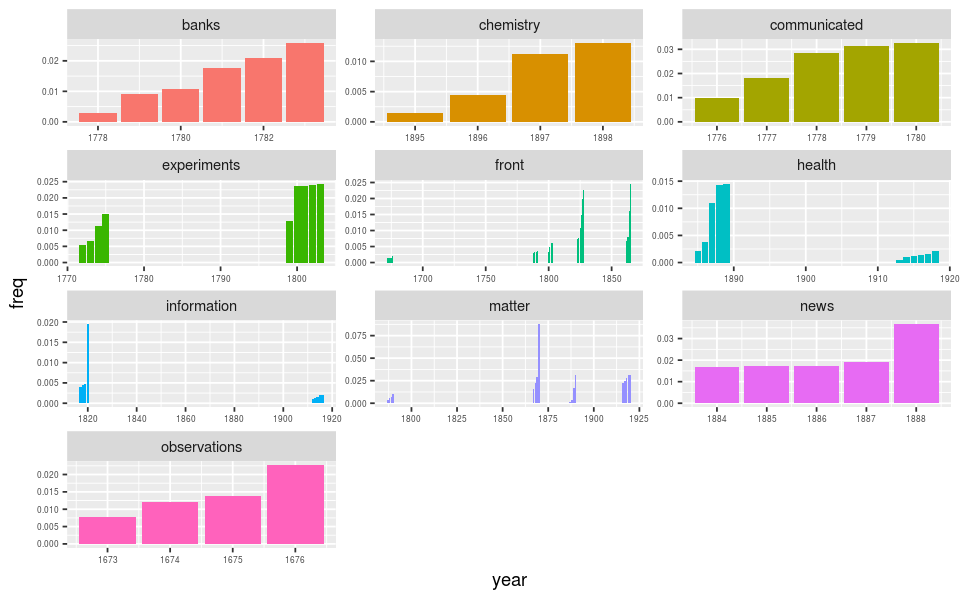

In [115]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

For all journal titles

We see that words that increase quickly are:
- 1650 - 1680, **_observations, front_**
- 1770 - 1780, **_experiments, banks, communicated_**
- 1800 - 1820, **_information_**
- 1850 - 1880, **_front, matter_**
- 1880 - 1900, **_chemistry, matter, news_**
- 1900 - 1930, **_information, matter,_**

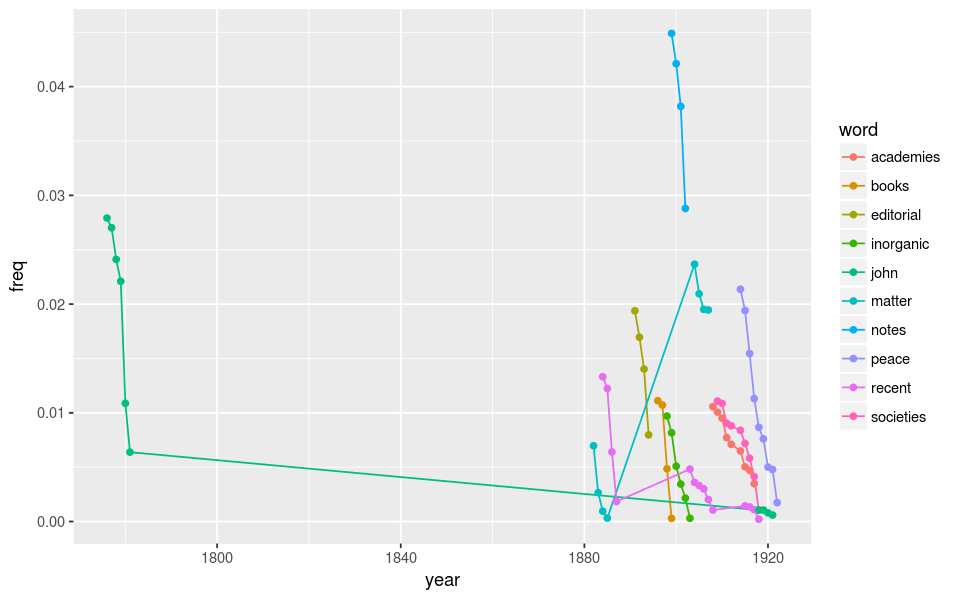

In [116]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

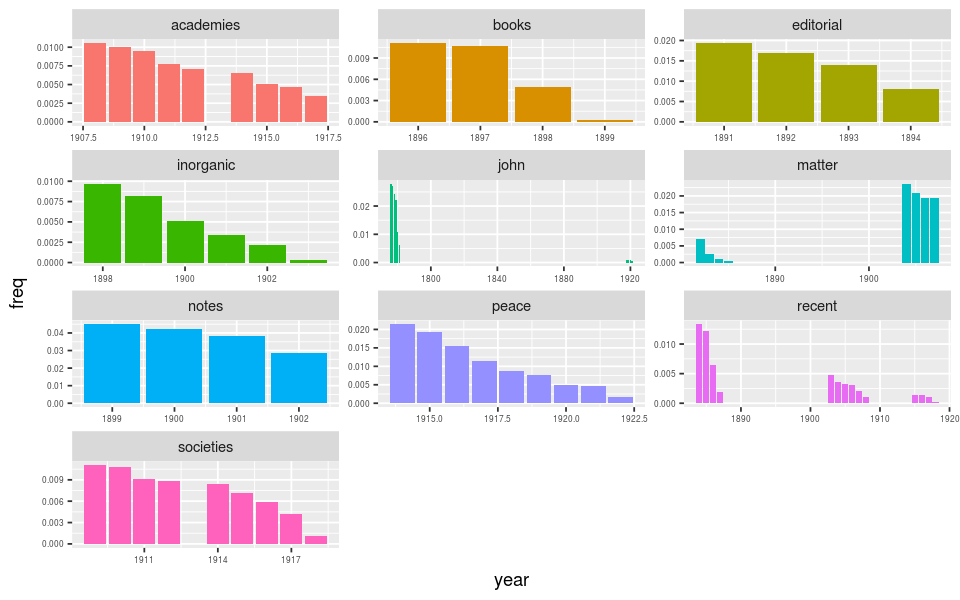

In [117]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

We see that words that decrease quickly are:
- 1760 - 1780, **_john_**
- 1870 - 1900, **_books, editorial, matter, recent_**
- 1900 - 1920, **_academies, matter, notes, peace, recent, societies_**

Let's look at title words that are the most consistently frequently used over all journals

In [118]:
title.words.all.frequently.used = title.words.all.stats %>%
    select(name, year, word, freq) %>%
    group_by(name, year) %>%
    top_n(20, freq) %>%
    ungroup() %>%
    group_by(name, word) %>%
    summarize(countsOnTopList = n()) %>%
    top_n(10, countsOnTopList)

In [119]:
title.words.all.frequently.used %>%
    arrange(-countsOnTopList)

name        word         countsOnTopList
1  allJournals observations 140            
2  allJournals account      128            
3  allJournals society      127            
4  allJournals matter       121            
5  allJournals letter       106            
6  allJournals communicated  86            
7  allJournals royal         86            
8  allJournals front         84            
9  allJournals american      73            
10 allJournals dr            73

Plot it

Joining, by = c("name", "word")


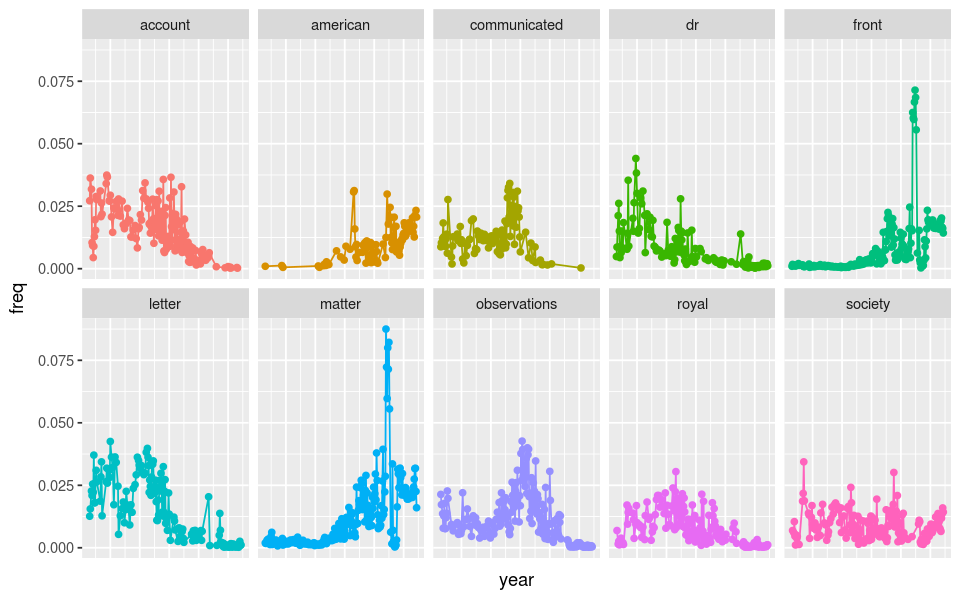

In [120]:
title.words.all.stats %>%
    inner_join(title.words.all.frequently.used) %>%
    ggplot() +
    aes(x = year, y = freq, color=word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, ncol = 5) +
    theme(legend.position = 'none',
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

Let's do an analysis on **article text** now

**For each Journal**

Get words in **text**

In [121]:
text.words.year = journals %>%
    inner_join(articles) %>%
    filter(!is.na(text), !is.na(year)) %>%
    select(name, text, year) %>%
    collect() %>%
    unnest_tokens(word, text) %>%
    anti_join(stop_words)
# text.words.year

Joining, by = "jnl_id"
Joining, by = "word"


Compute word count and frequency per year

In [122]:
text.words.stats = text.words.year %>%
    count(name, year, word) %>%
    ungroup() 
text.words.stats = text.words.stats %>%
    group_by(name, year) %>%
    summarize(count_year=sum(n)) %>%
    ungroup() %>%
    inner_join(text.words.stats) %>%
    mutate(freq = n / count_year)
text.words.stats %>% head()

Joining, by = c("name", "year")


name     year count_year word      n  freq        
1 AdvPeace 1834 25837      1         27 1.045013e-03
2 AdvPeace 1834 25837      1,2        1 3.870418e-05
3 AdvPeace 1834 25837      1.054.925  1 3.870418e-05
4 AdvPeace 1834 25837      1.4        1 3.870418e-05
5 AdvPeace 1834 25837      10         5 1.935209e-04
6 AdvPeace 1834 25837      10,000     1 3.870418e-05

Check year range

In [123]:
text.words.stats %>%
    group_by(name) %>%
    summarize(start=min(year),
              end=max(year))

name      start end 
1 AdvPeace  1834  1922
2 AmPhil    1769  1920
3 AmRev     1815  1922
4 RoyalPhil 1665  1869
5 Science   1880  1922

Compute year difference and frequency difference between years

In [124]:
text.words.freq = statsToFreq(text.words.stats)
# text.words.freq

**Journal AdvPeace text**

Same as before, we consider two periods: 1834 - 1856, 1889 - 1922

Filter _AdvPeace_ data

In [125]:
text.words.freq.journal = text.words.freq %>%
    filter(name == 'AdvPeace')

Find words that monotonically increase or decrease for at least 3 years

In [126]:
text.words.monoAsc = word_Mono_Increase_Period(text.words.freq.journal, 1834, 1856, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3, .parallel=TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoAsc

text.words.monoDesc = word_Mono_Decrease_Period(text.words.freq.journal, 1834, 1856, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3, .parallel=TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [127]:
top10IncreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name     word       freq_increase
1  AdvPeace government 0.0024503834 
2  AdvPeace con        0.0012482393 
3  AdvPeace party      0.0011740916 
4  AdvPeace richard    0.0010881718 
5  AdvPeace grand      0.0008612674 
6  AdvPeace sword      0.0008456278 
7  AdvPeace england    0.0007310223 
8  AdvPeace 4          0.0007308821 
9  AdvPeace bringing   0.0006686058 
10 AdvPeace thousand   0.0006339583

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name     word       freq_decrease
1  AdvPeace congress   -0.005410675 
2  AdvPeace peace      -0.003883444 
3  AdvPeace society    -0.002535860 
4  AdvPeace societies  -0.002084607 
5  AdvPeace england    -0.001811828 
6  AdvPeace convention -0.001657562 
7  AdvPeace esq        -0.001596328 
8  AdvPeace principles -0.001485324 
9  AdvPeace london     -0.001367501 
10 AdvPeace rev        -0.001215827

Join with frequency and plot

In [128]:
text.top10.increase.plot = text.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

text.top10.decrease.plot = text.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


In [129]:
options(repr.plot.height=5)

Monotonical increasing periods

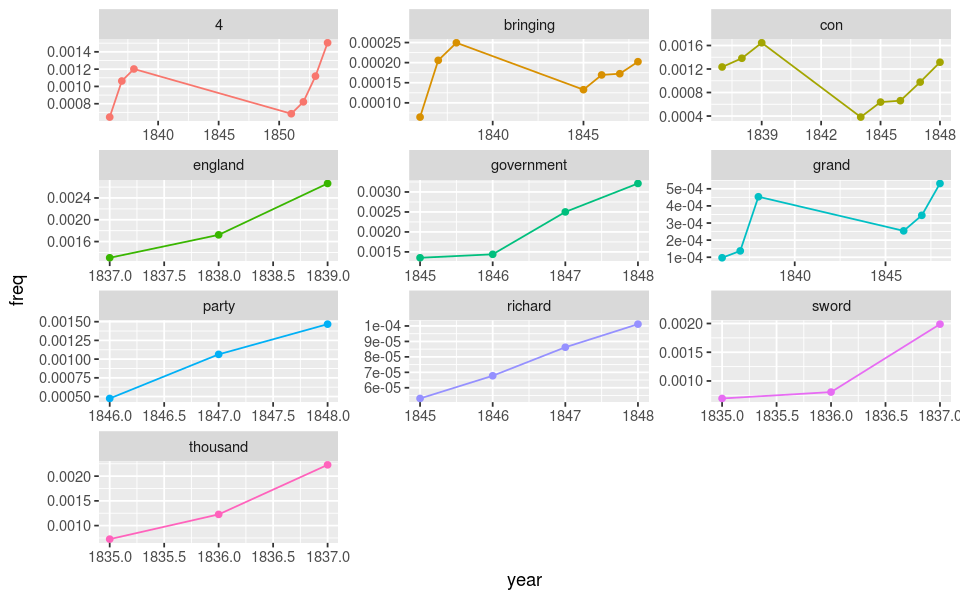

In [130]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

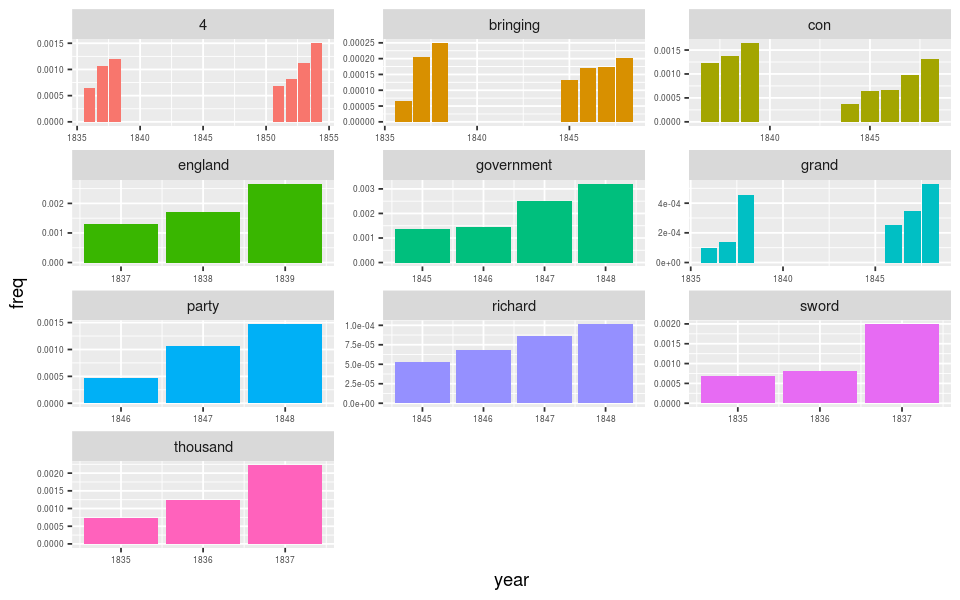

In [131]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Monotonical decreasing periods

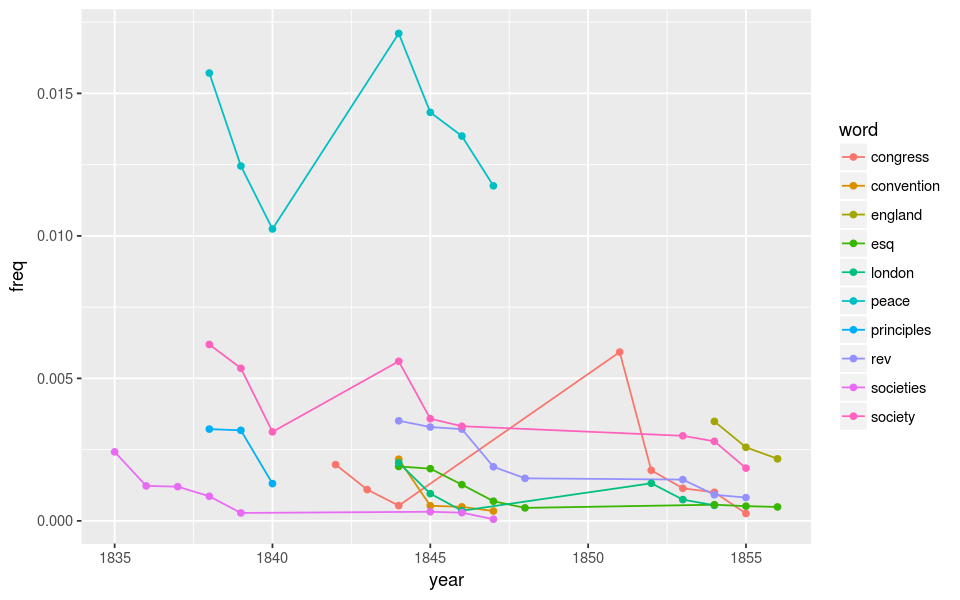

In [132]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point()

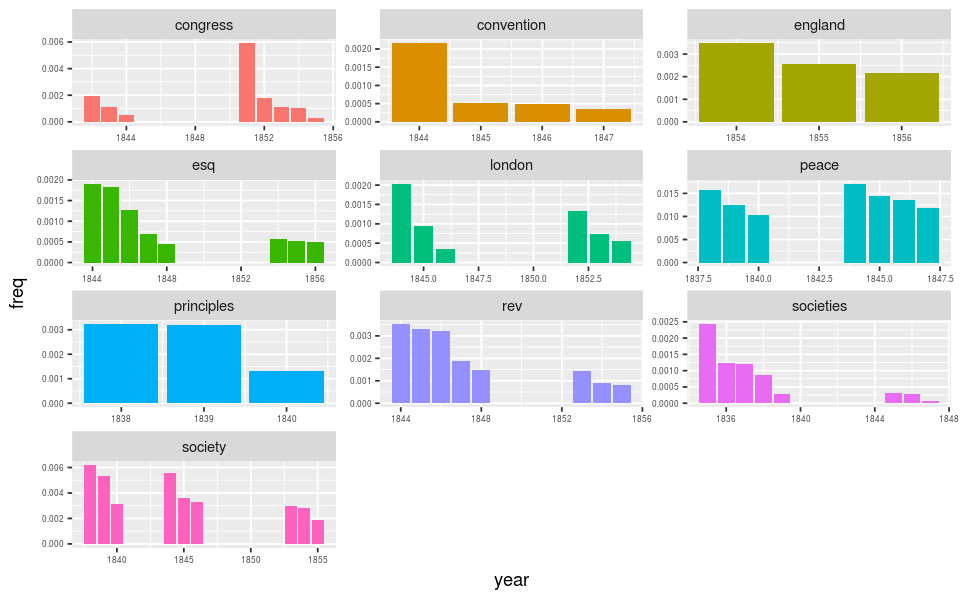

In [133]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Look at other periods: 1889 - 1922

Find words that monotonically increase or decrease for at least 3 years

In [134]:
text.words.monoAsc = word_Mono_Increase_Period(text.words.freq.journal, 1889, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3, .parallel=TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoAsc

text.words.monoDesc = word_Mono_Decrease_Period(text.words.freq.journal, 1889, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3, .parallel=TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [135]:
top10IncreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name     word       freq_increase
1  AdvPeace peace      0.008443235  
2  AdvPeace war        0.006013810  
3  AdvPeace hundred    0.003875224  
4  AdvPeace cts        0.003737247  
5  AdvPeace society    0.003666387  
6  AdvPeace price      0.003635026  
7  AdvPeace united     0.003632827  
8  AdvPeace pages      0.003632353  
9  AdvPeace washington 0.002962617  
10 AdvPeace military   0.002753300

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name     word      freq_decrease
1  AdvPeace peace     -0.009371577 
2  AdvPeace price     -0.004925539 
3  AdvPeace cts       -0.004568946 
4  AdvPeace mass      -0.004523977 
5  AdvPeace league    -0.004474235 
6  AdvPeace boston    -0.004365470 
7  AdvPeace secretary -0.004141531 
8  AdvPeace rev       -0.003799390 
9  AdvPeace hundred   -0.003784528 
10 AdvPeace pages     -0.003684235

Join with frequency and plot

In [136]:
text.top10.increase.plot = text.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

text.top10.decrease.plot = text.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


Monotonical increasing periods

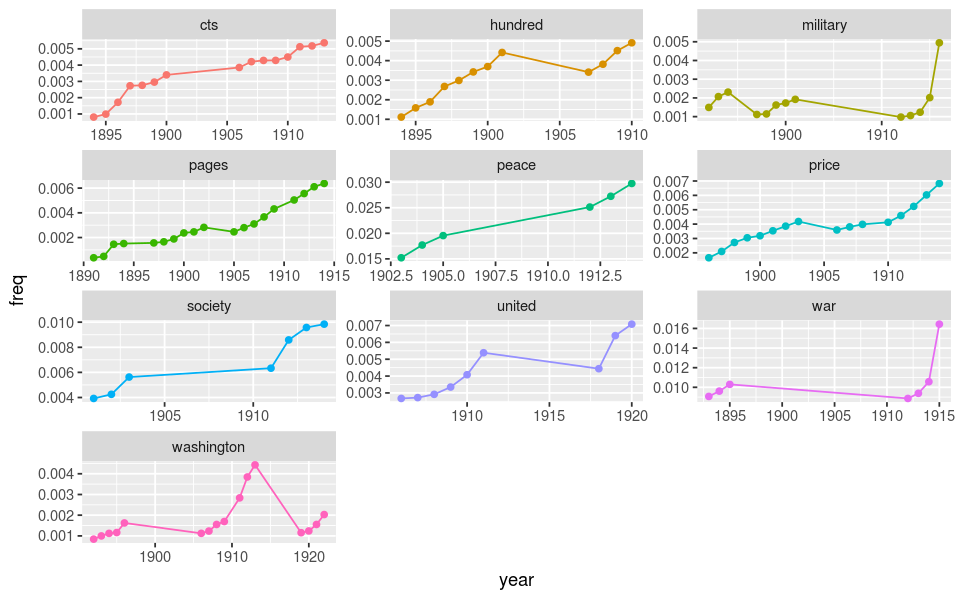

In [137]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

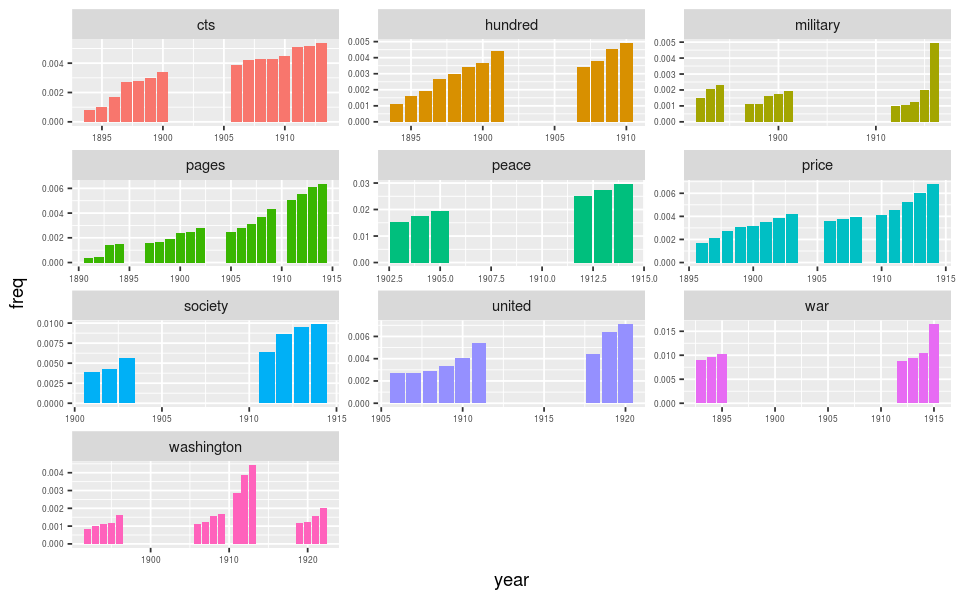

In [138]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Monotonical decreasing periods

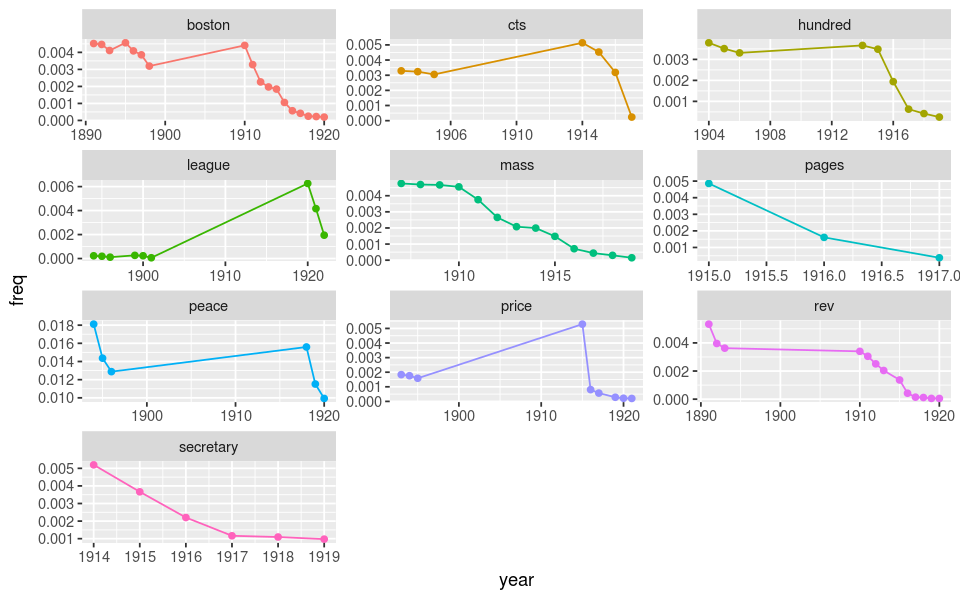

In [139]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

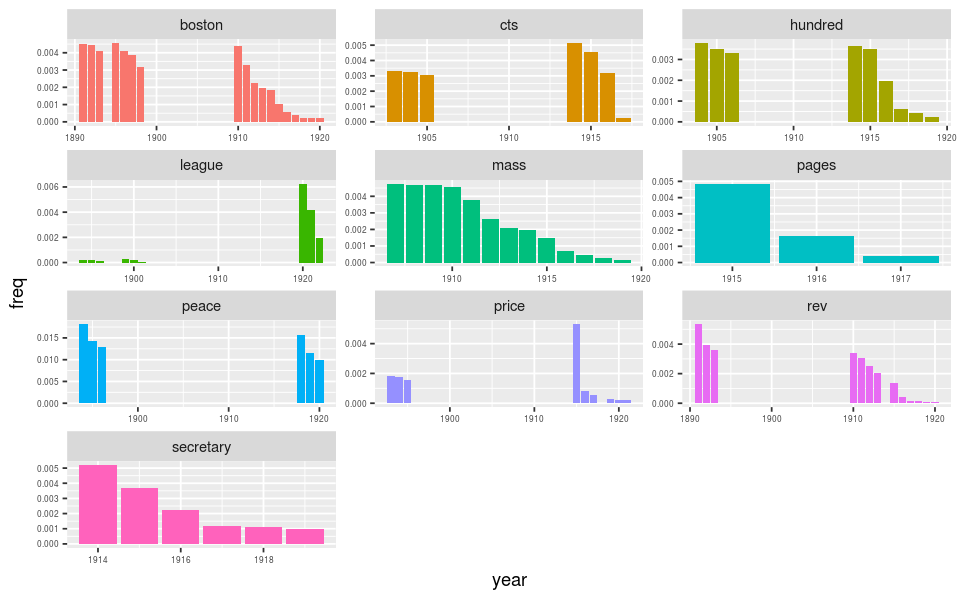

In [140]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

**Article text of journal AmPhil**

we just study words that appear in at least 10 years.

In [141]:
text.words.AmP = text.words.stats %>%
    filter(name == 'AmPhil') %>%
    count(name, word) %>%
    ungroup() %>%
    filter(nn > 10) %>%
    select(name, word)
# text.words.AmP

In [142]:
text.words.freq.journal = text.words.freq %>%
    inner_join(text.words.AmP)
# text.words.freq.journal

Joining, by = c("name", "word")


For each word, compute the frequency change from the year in which the word first appears to the year in which the word last time to appear.

Then find the top 10 increasing words and top 10 decreasing words

In [143]:
title.words.Amp.freq.diff = text.words.freq.journal %>%
    group_by(name, word) %>%
    summarize(total_freq_diff = sum(freq_diff)) %>%
    ungroup()
top10IncreaseWords = title.words.Amp.freq.diff %>%
    top_n(10, total_freq_diff)
top10DecreaseWords = title.words.Amp.freq.diff %>%
    filter(total_freq_diff < 0) %>%
    top_n(10, -total_freq_diff)
top10IncreaseWords
top10DecreaseWords

name   word       total_freq_diff
1  AmPhil cos        0.012112919    
2  AmPhil dt         0.019842092    
3  AmPhil fauna      0.011405751    
4  AmPhil fig        0.010534926    
5  AmPhil log        0.008133967    
6  AmPhil miocene    0.009002136    
7  AmPhil sin        0.010184868    
8  AmPhil tertiary   0.008847056    
9  AmPhil vertebrate 0.008348560    
10 AmPhil zone       0.009698075

name   word  total_freq_diff
1  AmPhil 2     -0.004405222   
2  AmPhil 3     -0.004720514   
3  AmPhil 5     -0.003670555   
4  AmPhil 7     -0.003721717   
5  AmPhil 8     -0.005474188   
6  AmPhil 9     -0.004189216   
7  AmPhil fo    -0.005595834   
8  AmPhil sun   -0.004305715   
9  AmPhil sun's -0.004004069   
10 AmPhil time  -0.006144288

Join these words with `text.words.stats` to get frequency and plot it

In [144]:
text.top10.increase.plot = top10IncreaseWords %>% select(name, word) %>%
    inner_join(text.words.stats) %>% select(word, year, freq)

text.top10.decrease.plot = top10DecreaseWords %>% select(name, word) %>%
    inner_join(text.words.stats) %>% select(word, year, freq)

Joining, by = c("name", "word")
Joining, by = c("name", "word")


Increased Words

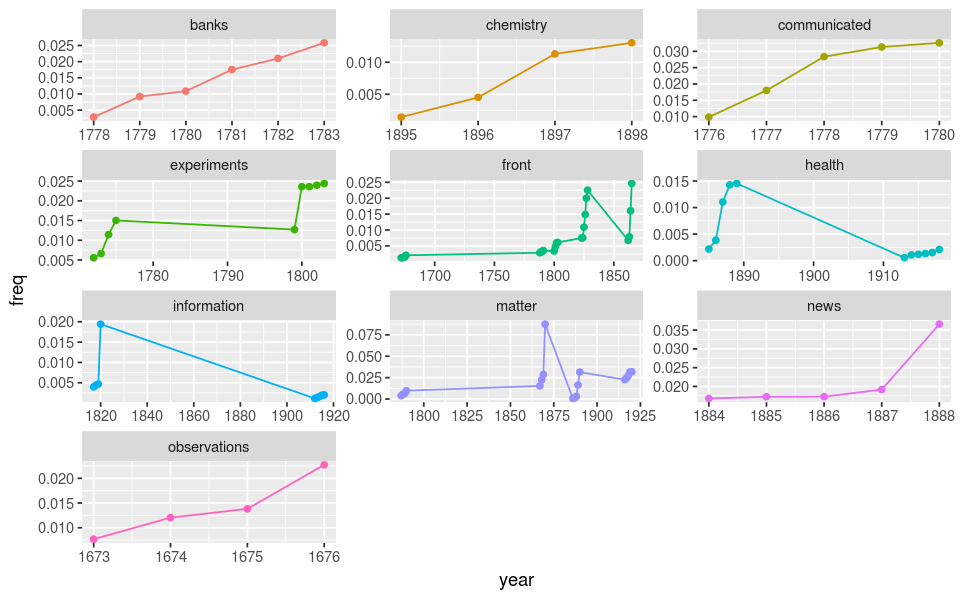

In [145]:
ggplot(title.top10.increase.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

Decreased words

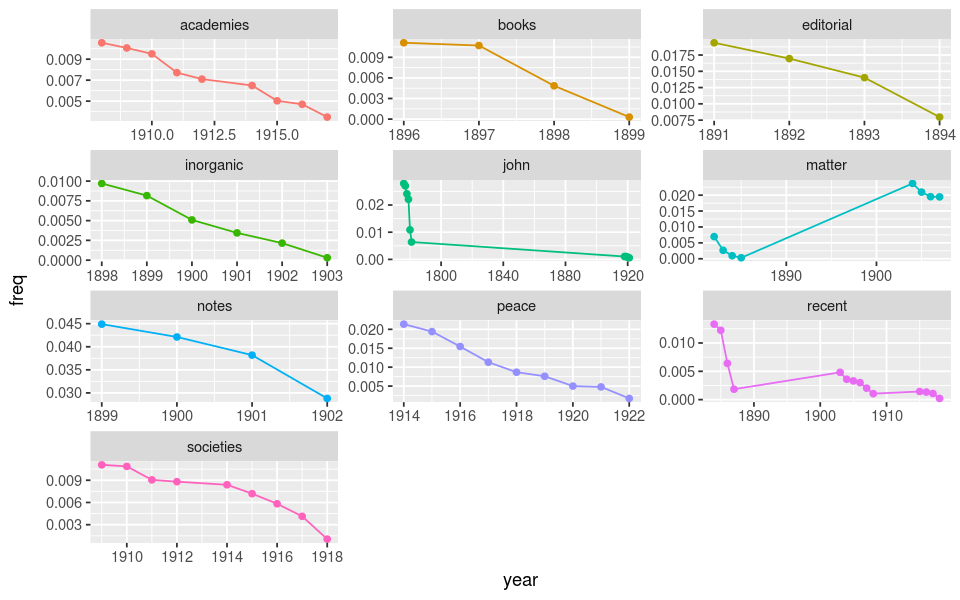

In [146]:
ggplot(title.top10.decrease.plot) +
    aes(x=year, y = freq, color = word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none')

**Article text of journal RoyalPhil**

We are going to look at periods: 1665 - 1869

Filter _RoyalPhil_ data

In [147]:
text.words.freq.journal = text.words.freq %>%
    filter(name == 'RoyalPhil')

Find words that monotonically increase or decrease for at least 3 years

In [148]:
text.words.monoAsc = word_Mono_Increase_Period(text.words.freq.journal, 1665, 1869, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# text.words.monoAsc

text.words.monoDesc = word_Mono_Decrease_Period(text.words.freq.journal, 1665, 1869, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# text.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [149]:
top10IncreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name      word        freq_increase
1  RoyalPhil 0           0.018287861  
2  RoyalPhil 4           0.016135259  
3  RoyalPhil 5           0.011213593  
4  RoyalPhil 9           0.010056135  
5  RoyalPhil 2           0.006314791  
6  RoyalPhil 3           0.006278900  
7  RoyalPhil 1           0.005502844  
8  RoyalPhil 20          0.005352682  
9  RoyalPhil 10          0.005306631  
10 RoyalPhil experiments 0.004882697

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name      word  freq_decrease
1  RoyalPhil 0     -0.012001631 
2  RoyalPhil 11    -0.011623775 
3  RoyalPhil 10    -0.011554439 
4  RoyalPhil water -0.010247407 
5  RoyalPhil 1     -0.007754317 
6  RoyalPhil 16    -0.005915789 
7  RoyalPhil 25    -0.005808620 
8  RoyalPhil 19    -0.005556846 
9  RoyalPhil 27    -0.005489324 
10 RoyalPhil ditto -0.004918115

Join with frequency and plot

In [150]:
text.top10.increase.plot = text.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

text.top10.decrease.plot = text.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


Monotonical increasing interval

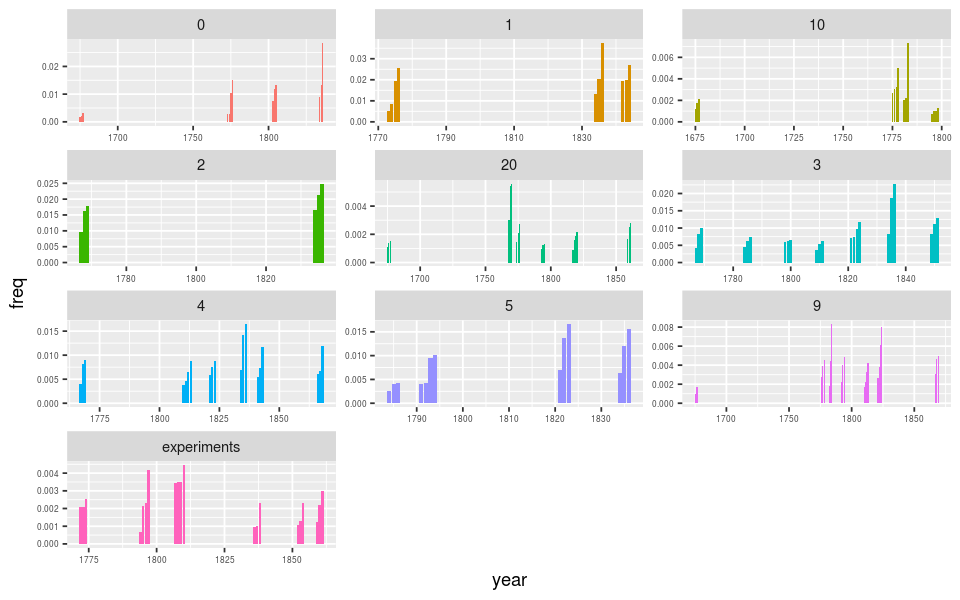

In [151]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Monotonical decreasing interval

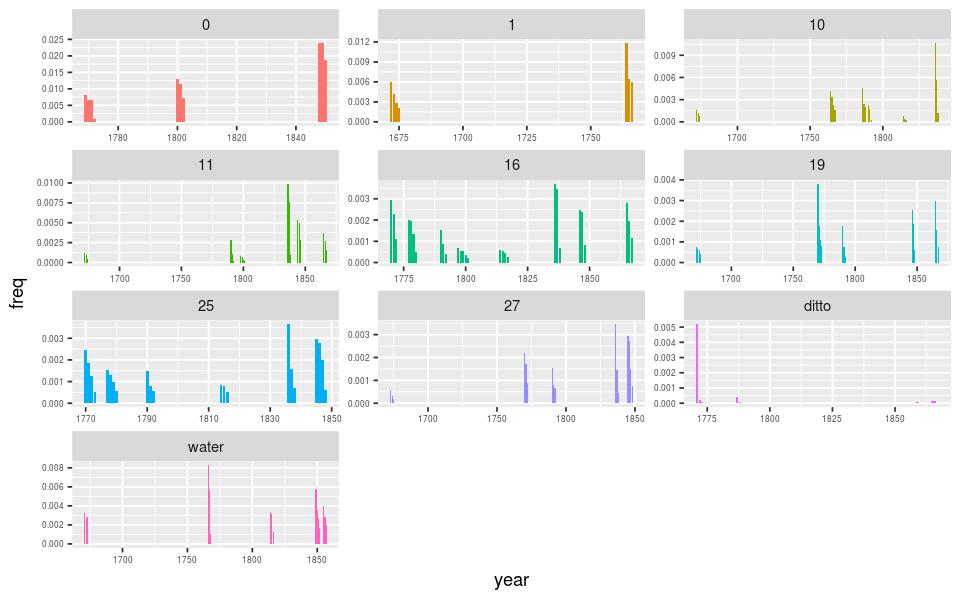

In [152]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

**Article text of journal AmRev**

We are going to look at two periods: 1815 - 1922

Filter _AmRev_ data

In [153]:
text.words.freq.journal = text.words.freq %>%
    filter(name == 'AmRev')

Find words that monotonically increase or decrease for at least 3 years

In [154]:
text.words.monoAsc = word_Mono_Increase_Period(text.words.freq.journal, 1815, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# text.words.monoAsc

text.words.monoDesc = word_Mono_Decrease_Period(text.words.freq.journal, 1815, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3) %>%
    select(word, year) %>%
    distinct()
# text.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [155]:
top10IncreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name  word    freq_increase
1  AmRev pp      0.004046608  
2  AmRev de      0.002222245  
3  AmRev public  0.002193023  
4  AmRev powers  0.002011354  
5  AmRev silver  0.001864661  
6  AmRev slavery 0.001732571  
7  AmRev army    0.001616880  
8  AmRev money   0.001613856  
9  AmRev ed      0.001583628  
10 AmRev league  0.001567573

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name  word    freq_decrease
1  AmRev war     -0.005981165 
2  AmRev de      -0.004481773 
3  AmRev pp      -0.002838971 
4  AmRev ed      -0.002785089 
5  AmRev german  -0.002310371 
6  AmRev church  -0.002077387 
7  AmRev country -0.002043854 
8  AmRev fair    -0.001853977 
9  AmRev god     -0.001774417 
10 AmRev united  -0.001681089

Join with frequency and plot

In [156]:
text.top10.increase.plot = text.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

text.top10.decrease.plot = text.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


Monotonical increasing interval

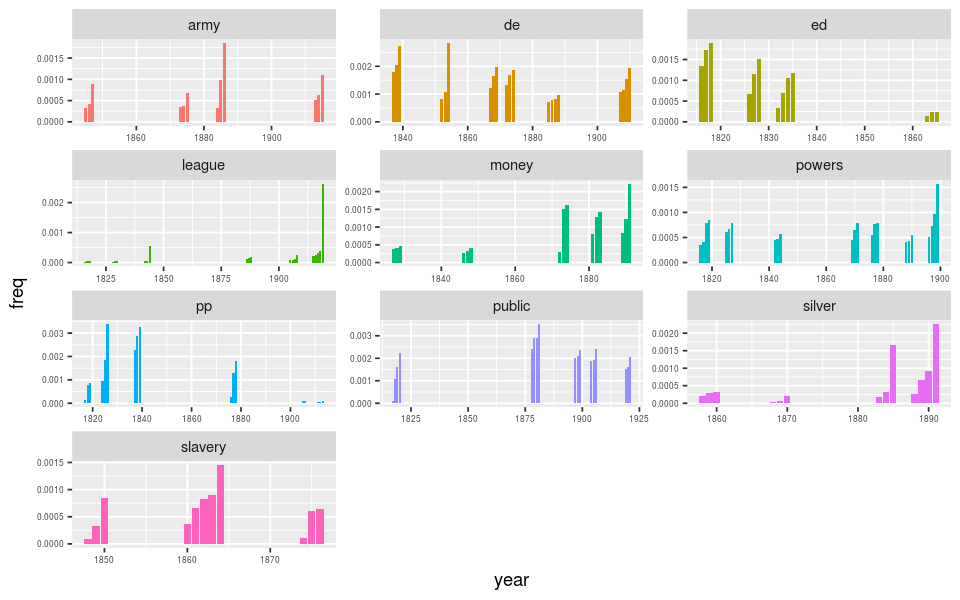

In [157]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Monotonical decreasing interval

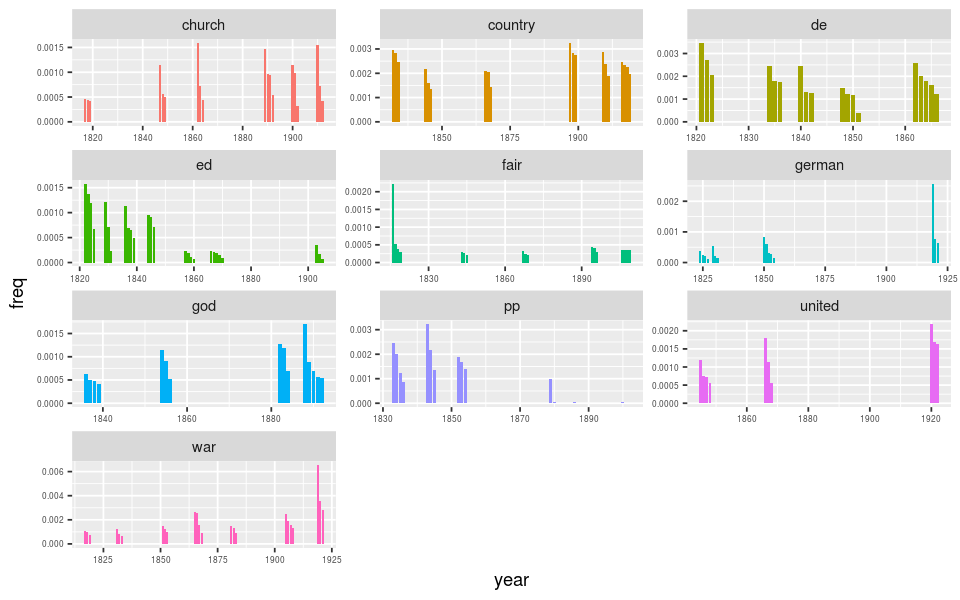

In [158]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

**Article titles of journal Science**

We are going to look at period: 1880 - 1922

Filter _Science_ data

In [159]:
text.words.freq.journal = text.words.freq %>%
    filter(name == 'Science')

Find words that monotonically increase or decrease for at least 3 years

In [160]:
text.words.monoAsc = word_Mono_Increase_Period(text.words.freq.journal, 1880, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3, .parallel = TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoAsc

text.words.monoDesc = word_Mono_Decrease_Period(text.words.freq.journal, 1880, 1922, 3) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 3, .parallel = TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoDesc

Find top 10 increased or decreased words during its monotonical periods.

In [161]:
top10IncreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = text.words.freq.journal %>%
    inner_join(text.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name    word       freq_increase
1  Science war        0.003013073  
2  Science university 0.003010076  
3  Science science    0.002417581  
4  Science 1          0.001867282  
5  Science research   0.001855599  
6  Science 1922       0.001836693  
7  Science scientific 0.001792276  
8  Science school     0.001682512  
9  Science species    0.001449255  
10 Science book       0.001430541

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name    word       freq_decrease
1  Science 1          -0.003144564 
2  Science war        -0.002699336 
3  Science professor  -0.002617443 
4  Science university -0.001677665 
5  Science address    -0.001271152 
6  Science 1902       -0.001238073 
7  Science hundred    -0.001220213 
8  Science book       -0.001218501 
9  Science 1909       -0.001204616 
10 Science 1908       -0.001200830

Join with frequency and plot

In [162]:
text.top10.increase.plot = text.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

text.top10.decrease.plot = text.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(text.words.stats)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


Monotonical increasing interval

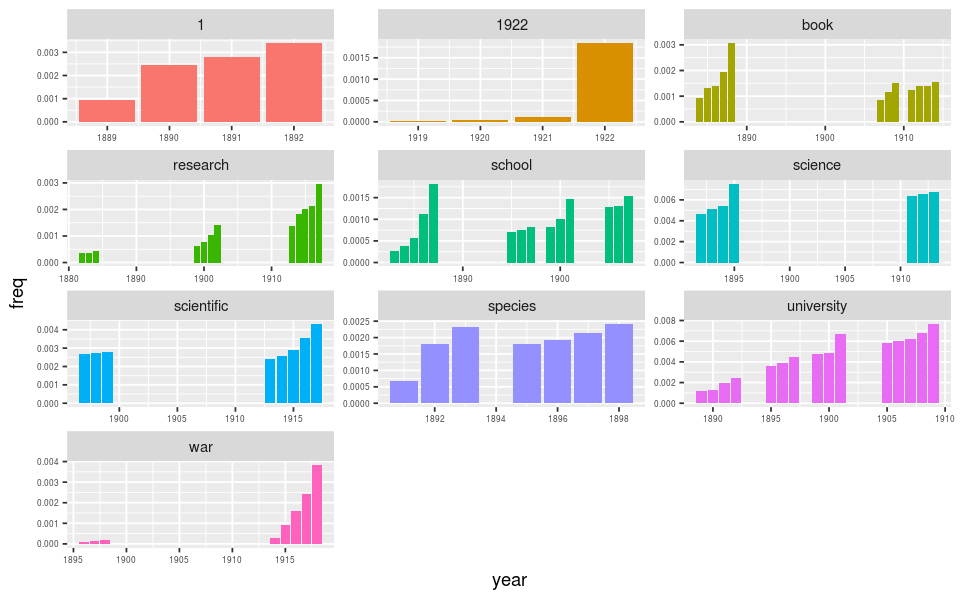

In [163]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Monotonical decreasing interval

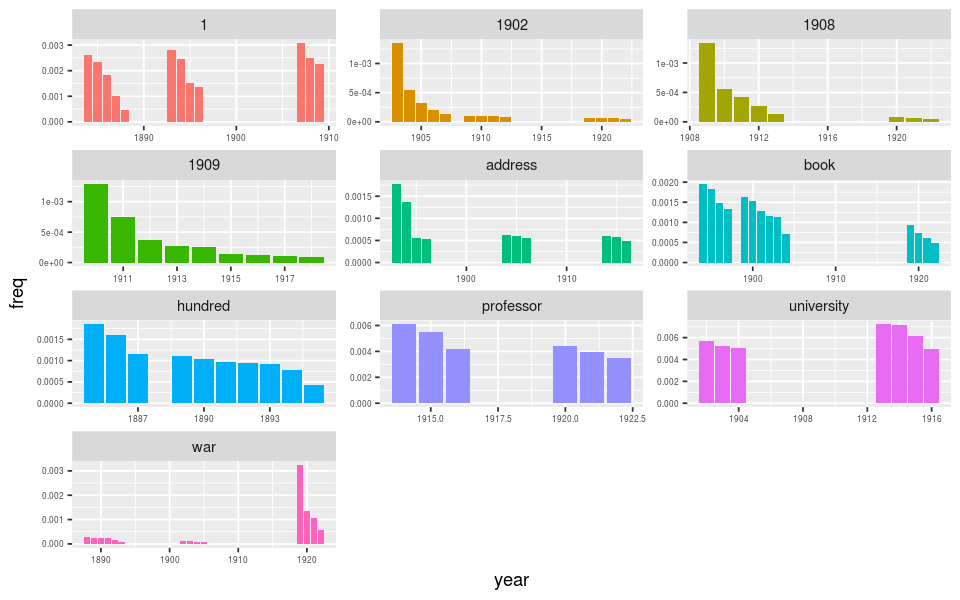

In [164]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Let's look at words that are the most consistently frequently used.

In [165]:
text.words.frequently.used = text.words.stats %>%
    select(name, year, word, freq) %>%
    group_by(name, year) %>%
    top_n(20, freq) %>%
    ungroup() %>%
    group_by(name, word) %>%
    summarize(countsOnTopList = n()) %>%
    top_n(10, countsOnTopList)

In [166]:
text.top5.stable.plot = text.words.stats %>%
    select(name, year, word, freq) %>%
    inner_join(text.words.frequently.used %>%
        group_by(name) %>%
        arrange(-countsOnTopList) %>%
        mutate(rank = row_number()) %>%
        ungroup() %>%
        filter(rank < 6))

Joining, by = c("name", "word")


In [167]:
options(repr.plot.height = 10)

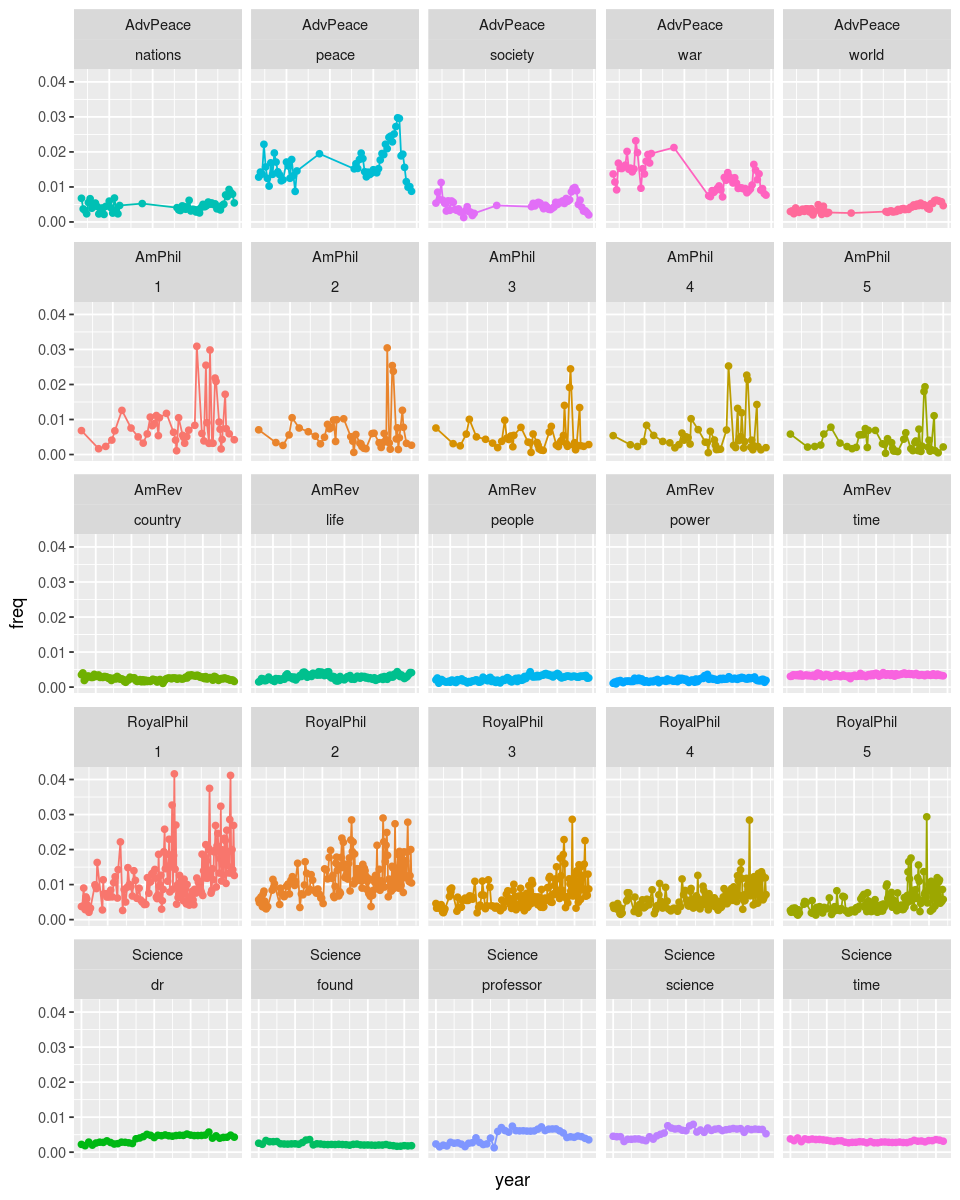

In [168]:
ggplot(text.top5.stable.plot) +
    aes(x = year, y = freq, color=word) +
    geom_line() +
    geom_point() +
    facet_wrap(name~word, ncol = 5, scales = 'free_x') +
    theme(legend.position = 'none',
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

**Analysis of text words for all journals**

In [169]:
text.words.year.all = text.words.stats %>%
    select(name, year, count_year) %>%
    distinct() %>%
    group_by(year) %>%
    summarize(count_year = sum(count_year)) %>%
    ungroup()

text.words.all.stats = text.words.stats %>%
    group_by(year, word) %>%
    summarize(n = sum(n)) %>%
    ungroup() %>% 
    inner_join(text.words.year.all) %>%
    mutate(freq = n / count_year,
           name = "allJournals") %>%
    select(name, year, count_year, word, n, freq)
# text.words.all.stats

Joining, by = "year"


Check year range

In [170]:
text.words.all.stats %>%
    group_by(name) %>%
    summarize(start=min(year),
              end=max(year))

name        start end 
1 allJournals 1665  1922

In [171]:
text.words.all.freq = statsToFreq(text.words.all.stats)
# text.words.all.freq

Find words that monotonically increase or decrease for at least 4 years

In [172]:
text.words.monoAsc = word_Mono_Increase_Period(text.words.all.freq, 1665, 1922, 4) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 4, .parallel = TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoAsc

text.words.monoDesc = word_Mono_Decrease_Period(text.words.all.freq, 1665, 1922, 4) %>% 
    mutate(row = row_number()) %>%
    plyr::ddply(~row, map_Word_To_Year, 4, .parallel = TRUE) %>%
    select(word, year) %>%
    distinct()
# text.words.monoDesc

word        year
1     24th        1669
2     24th        1670
3     24th        1671
4     24th        1672
5     accurate    1669
⋮     ⋮           ⋮   
73874 yacht       1922
73875 zeitschrift 1919
73876 zeitschrift 1920
73877 zeitschrift 1921
73878 zeitschrift 1922

word      year
1     1668      1669
2     1668      1670
3     1668      1671
4     1668      1672
5     coats     1669
⋮     ⋮         ⋮   
77729 wrought   1919
77730 wrought   1920
77731 wrought   1921
77732 wrought   1922
77733 zealously 1922

Find top 10 increased or decreased words during its monotonical periods.

In [173]:
top10IncreaseWords = text.words.all.freq %>%
    inner_join(text.words.monoAsc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_increase = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(-freq_increase) %>%
    head(10)
top10IncreaseWords

top10DecreaseWords = text.words.all.freq %>%
    inner_join(text.words.monoDesc) %>%
    select(name, word, year, freq, freq_diff) %>%
    group_by(name, word) %>%
    summarize(freq_decrease = sum(freq_diff)) %>%
    ungroup() %>%
    arrange(freq_decrease) %>%
    head(10)
top10DecreaseWords

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name        word  freq_increase
1  allJournals 1     0.015799078  
2  allJournals 0     0.009890433  
3  allJournals 7     0.002815507  
4  allJournals peace 0.002305460  
5  allJournals sin   0.002282660  
6  allJournals cos   0.002057518  
7  allJournals 15    0.002021702  
8  allJournals 5     0.001999884  
9  allJournals 3     0.001968463  
10 allJournals fine  0.001928575

Joining, by = c("word", "year")
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

name        word        freq_decrease
1  allJournals 7           -0.007620865 
2  allJournals 2           -0.004379586 
3  allJournals 1           -0.004354472 
4  allJournals gas         -0.004342267 
5  allJournals 4           -0.003879788 
6  allJournals 5           -0.003749542 
7  allJournals 6           -0.003649356 
8  allJournals experiments -0.003477356 
9  allJournals 3           -0.003473216 
10 allJournals war         -0.003427238

Join with frequency and plot

In [174]:
text.top10.increase.plot = text.words.monoAsc %>%
    inner_join(top10IncreaseWords %>% select(name, word)) %>%
    inner_join(text.words.all.stats)

text.top10.decrease.plot = text.words.monoDesc %>%
    inner_join(top10DecreaseWords %>% select(name, word)) %>%
    inner_join(text.words.all.stats)

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")
Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”Joining, by = c("word", "year", "name")


Monotonical increasing

In [175]:
options(repr.plot.height=5)

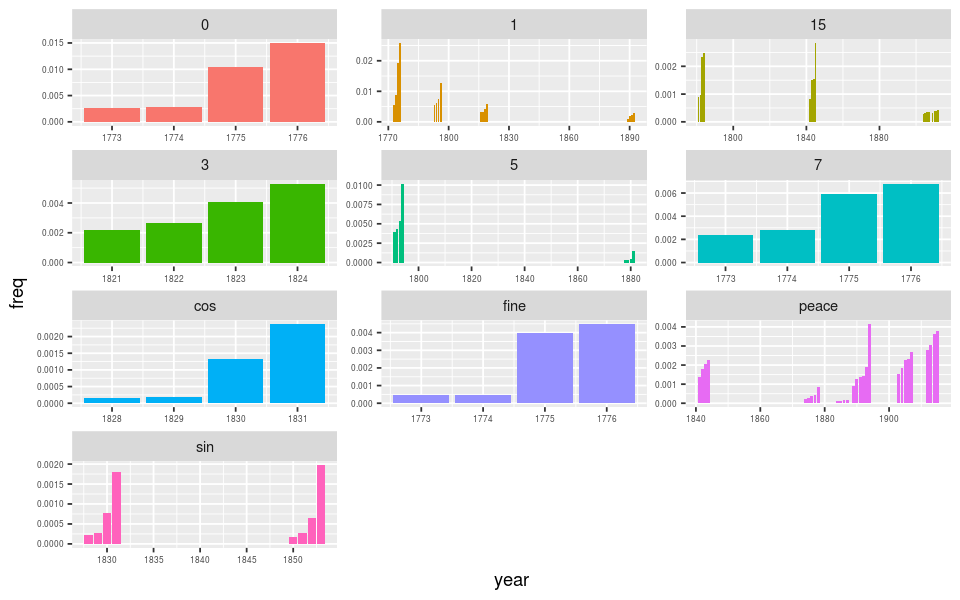

In [176]:
ggplot(text.top10.increase.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Monotonical decreasing

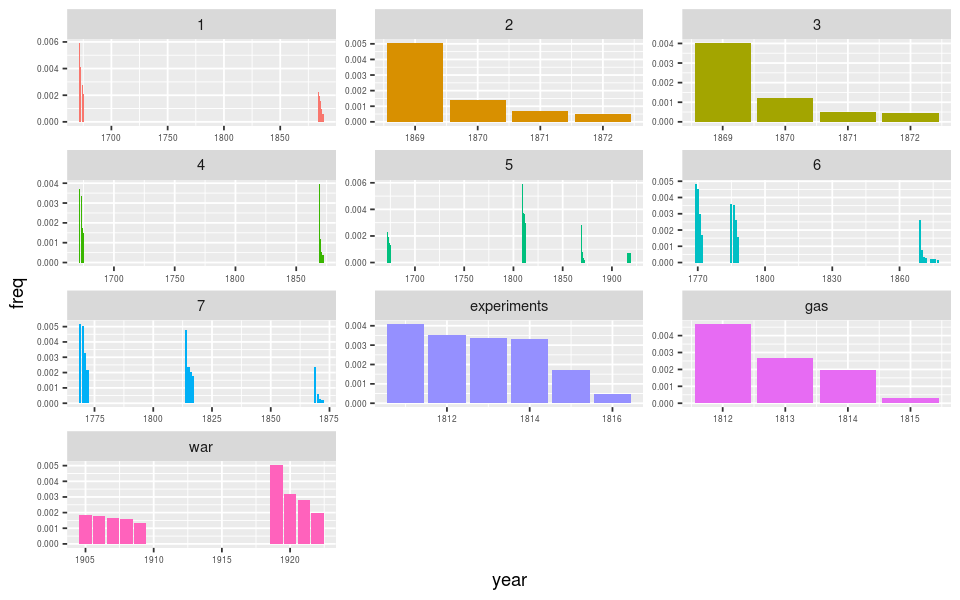

In [177]:
ggplot(text.top10.decrease.plot) +
    aes(x=year, y=freq, fill=word) +
    geom_bar(stat = 'identity', position = 'dodge') +
    facet_wrap(~word, scales = 'free', ncol = 3) +
    theme(legend.position = 'none',
          axis.text=element_text(size=5))

Let's look at text words that are the most consistently frequently used over all journals

In [178]:
text.words.all.frequently.used = text.words.all.stats %>%
    select(name, year, word, freq) %>%
    group_by(name, year) %>%
    top_n(20, freq) %>%
    ungroup() %>%
    group_by(name, word) %>%
    summarize(countsOnTopList = n()) %>%
    top_n(10, countsOnTopList)

In [179]:
text.top10.stable.plot = text.words.all.stats %>%
    select(name, year, word, freq) %>%
    inner_join(text.words.all.frequently.used)

Joining, by = c("name", "word")


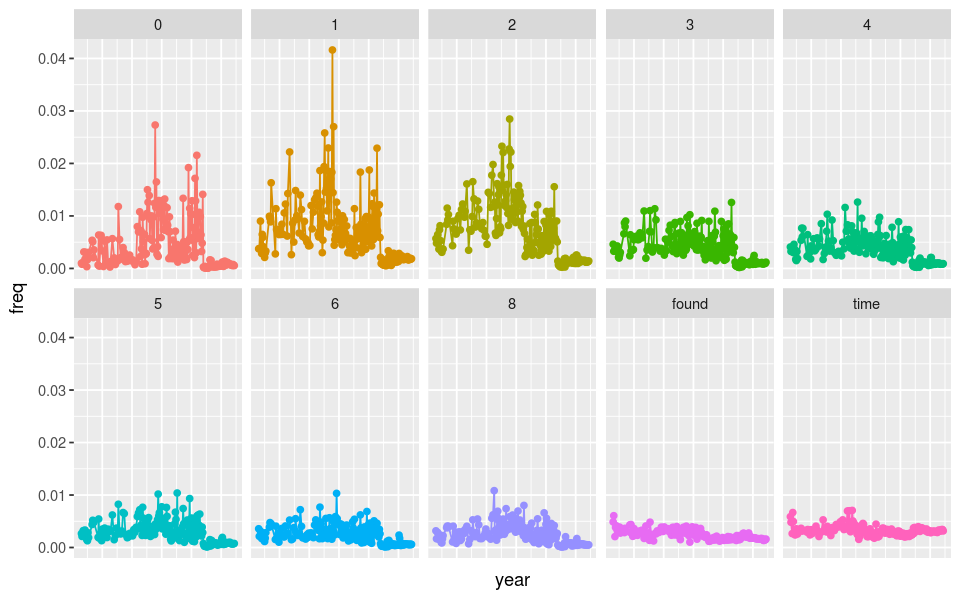

In [180]:
ggplot(text.top10.stable.plot) +
    aes(x = year, y = freq, color=word) +
    geom_line() +
    geom_point() +
    facet_wrap(~word, ncol = 5) +
    theme(legend.position = 'none',
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

Numbers are consistently frequently used in journals' text

### Text Similarity

Compute term frequency

In [181]:
journal_tf = corpus.words.stats %>%
    group_by(name) %>%
    mutate(tf = totalCount / sum(totalCount))
# journal_tf

name     word     totalCount tf          
1       AdvPeace __       18         1.482261e-06
2       AdvPeace ___       7         5.764348e-07
3       AdvPeace ______    2         1.646957e-07
4       AdvPeace _______   2         1.646957e-07
5       AdvPeace ________  4         3.293913e-07
⋮       ⋮        ⋮        ⋮          ⋮           
2116727 Science  zygæna   1          1.415454e-08
2116728 Science  β        2          2.830909e-08
2116729 Science  γ        2          2.830909e-08
2116730 Science  δ        1          1.415454e-08
2116731 Science  μ        1          1.415454e-08

Spread _journal name_ to form TF vectors for each journal

In [182]:
term_freqs = journal_tf %>%
    select(name, word, tf) %>%
    spread(name, tf, fill=0)
# term_freqs

Compute correlation coefficient matrix

In [183]:
corMat = term_freqs %>% select(-word) %>% cor()
corMat

AdvPeace  AmPhil    AmRev     RoyalPhil Science  
AdvPeace  1.0000000 0.9735472 0.9922905 0.9679596 0.9895381
AmPhil    0.9735472 1.0000000 0.9749339 0.9943455 0.9863766
AmRev     0.9922905 0.9749339 1.0000000 0.9693889 0.9907571
RoyalPhil 0.9679596 0.9943455 0.9693889 1.0000000 0.9795634
Science   0.9895381 0.9863766 0.9907571 0.9795634 1.0000000

Convert matrix to dataframe and plot heatmap

In [184]:
corMat.plot = as.data.frame(as.table(corMat)) %>%
    mutate(Freq = round(Freq, 3)) %>%
    rename(CCP = Freq)

In [185]:
options(repr.plot.width = 6,
        repr.plot.height = 5)

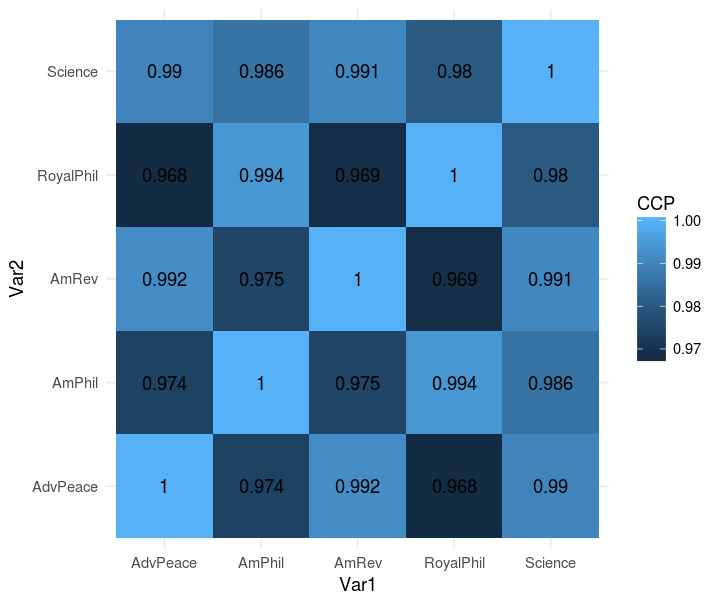

In [186]:
ggplot(corMat.plot) +
    aes(x=Var1, y=Var2, fill=CCP) +
    geom_tile() +
    geom_text(mapping=aes(label = CCP)) +
    theme_minimal()

**_Journal RoyalPhil and AmPhil_** are the most similar.

**_Journal RoyalPhil and AdvPeace_** are the least similar.

### Divergence Over Time

Get **_AmPhil and RoyalPhil_** data

Full join title word counts with text word counts

In [187]:
corpus.words.stats = full_join(title.words.stats %>%
    select(name, year, word, n_title = n) %>%
    filter(name == 'AmPhil' | name=='RoyalPhil'),
          text.words.stats %>%
    select(name, year, word, n_text = n) %>%
    filter(name == 'AmPhil' | name=='RoyalPhil')) %>%
    mutate(n_title = ifelse(is.na(n_title), 0, n_title),
           n_text = ifelse(is.na(n_text), 0, n_text),
           count = n_title + n_text) %>%
    select(name, year, word, count)
# corpus.words.stats

Joining, by = c("name", "year", "word")


In [188]:
journal_year_word_counts = corpus.words.stats %>%
    spread(name, count, fill=0) %>%
    filter(year > 1700, year < 1860)

Define a function to compute text divergence of two document

In [189]:
text_divergence = function(p, q) {
    prob_p = (p + 1) / (sum(p) + length(p))
    prob_q = (q + 1) / (sum(q) + length(q))
    prob_p * (log2(prob_p) - log2(prob_q))
}

In [190]:
sim_over_time = journal_year_word_counts %>%
    group_by(year) %>%
    mutate(divergence = text_divergence(AmPhil, RoyalPhil)) %>%
    ungroup()

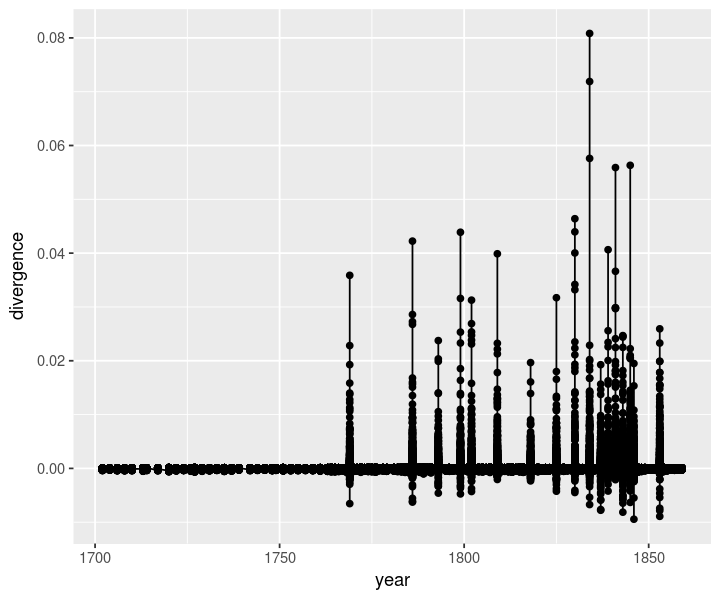

In [191]:
ggplot(sim_over_time) +
    aes(x=year, y = divergence) +
    geom_line() +
    geom_point()

It seems that from year 1825, divergence becomes bigger.